# Team EDA Baseline (Full Data + R2 Download)

This notebook is the teammate-ready baseline for EDA on the full V1 merged dataset (no additional cleaning/feature engineering in this notebook).

Scope:
- Validate `scripts/r2.env` configuration
- Optionally run `scripts/download_from_r2.sh` to fetch `datasets/<DATASET_VERSION>/`
- Load full parquet partitions as a DuckDB view (`spotify_full`). Pandas is not possible because Dataset is too big for a full EDA.
- Run starter SQL EDA queries (shape, null rates, top regions/charts, yearly streams, audio feature summary)

## 1) Load Project Dependencies and Paths

In [69]:
from pathlib import Path
import os
import re
import json
import subprocess
from typing import Dict, List, Tuple
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != "Project_Information":
    for candidate in [Path.cwd(), *Path.cwd().parents]:
        if (candidate / "scripts").exists() and (candidate / "datasets").exists():
            NOTEBOOK_DIR = candidate / "Project_Information" if (candidate / "Project_Information").exists() else candidate
            break

REPO_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "Project_Information" else NOTEBOOK_DIR
SCRIPTS_DIR = REPO_ROOT / "scripts"
DEFAULT_DATASET_VERSION = "v1"
DEFAULT_DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DEFAULT_DATASET_VERSION
R2_ENV_PATH = SCRIPTS_DIR / "r2.env"
R2_ENV_EXAMPLE_PATH = SCRIPTS_DIR / "r2.env.example"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "team_eda_baseline"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Scripts dir: {SCRIPTS_DIR}")
print(f"Default download root: {DEFAULT_DOWNLOAD_ROOT}")
print(f"R2 env file: {R2_ENV_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Repo root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB
Scripts dir: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/scripts
Default download root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
R2 env file: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/scripts/r2.env
Output dir: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/Project_Information/outputs/team_eda_baseline


## 2) Parse and Validate `scripts/r2.env` Configuration

In [70]:
REQUIRED_R2_KEYS = [
    "R2_ENDPOINT",
    "R2_BUCKET",
    "AWS_ACCESS_KEY_ID",
    "AWS_SECRET_ACCESS_KEY",
    "DATASET_VERSION",
]


def _strip_balanced_quotes(value: str) -> str:
    if len(value) >= 2 and ((value[0] == '"' and value[-1] == '"') or (value[0] == "'" and value[-1] == "'")):
        return value[1:-1]
    return value


def parse_env_file(env_path: Path) -> Tuple[Dict[str, str], List[str]]:
    parsed: Dict[str, str] = {}
    errors: List[str] = []

    if not env_path.exists():
        errors.append(f"Missing env file: {env_path}")
        return parsed, errors

    for line_no, raw_line in enumerate(env_path.read_text(encoding="utf-8").splitlines(), start=1):
        line = raw_line.strip()
        if not line or line.startswith("#"):
            continue
        if "=" not in line:
            errors.append(f"Line {line_no}: missing '=' separator")
            continue

        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()

        if not re.fullmatch(r"[A-Za-z_][A-Za-z0-9_]*", key):
            errors.append(f"Line {line_no}: invalid key '{key}'")
            continue

        dbl_quote_count = value.count('"')
        sgl_quote_count = value.count("'")
        if dbl_quote_count % 2 != 0 or sgl_quote_count % 2 != 0:
            errors.append(
                f"Line {line_no}: malformed quotes for key '{key}' -> {value!r}"
            )
            continue

        normalized = _strip_balanced_quotes(value).strip()

        if normalized.endswith('"') or normalized.endswith("'"):
            errors.append(
                f"Line {line_no}: value for '{key}' appears to have a trailing quote -> {value!r}"
            )

        parsed[key] = normalized

    missing = [k for k in REQUIRED_R2_KEYS if not parsed.get(k)]
    if missing:
        errors.append(f"Missing required keys: {missing}")

    return parsed, errors


r2_config, r2_config_errors = parse_env_file(R2_ENV_PATH)

if r2_config_errors:
    print("❌ r2.env validation failed:")
    for err in r2_config_errors:
        print(f"  - {err}")
    if R2_ENV_EXAMPLE_PATH.exists():
        print(f"\nTemplate available at: {R2_ENV_EXAMPLE_PATH}")
else:
    print("✅ r2.env validation passed")
    display(pd.DataFrame([r2_config]).T.rename(columns={0: "value"}))

✅ r2.env validation passed


,value
R2_ENDPOINT,https://a96b93c5d97cddb48fc674255fb687c7.r2.cl...
R2_BUCKET,ml-group-ab-datasets
AWS_ACCESS_KEY_ID,b4f318900453ff77a06d530e454aa330
AWS_SECRET_ACCESS_KEY,e196e275699090f32d71db4854983855b8b3fc05905a80...
DATASET_VERSION,v1


## 3) Implement Safe Environment Variable Export for Shell Commands

In [71]:
def build_sanitized_env(base_env: Dict[str, str], overrides: Dict[str, str] | None = None) -> Dict[str, str]:
    if r2_config_errors:
        raise ValueError("Cannot build environment: r2.env is invalid.")

    env = dict(os.environ)
    for key in REQUIRED_R2_KEYS:
        env[key] = str(base_env[key]).strip()

    if overrides:
        for k, v in overrides.items():
            if v is not None:
                env[k] = str(v)

    return env


def run_bash_script(script_path: Path, env: Dict[str, str], cwd: Path, timeout: int = 3600) -> subprocess.CompletedProcess:
    if not script_path.exists():
        raise FileNotFoundError(f"Missing script: {script_path}")

    cmd = ["bash", str(script_path)]
    result = subprocess.run(
        cmd,
        cwd=str(cwd),
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
    )

    print("--- stdout ---")
    print(result.stdout[-4000:] if result.stdout else "<empty>")
    print("--- stderr ---")
    print(result.stderr[-4000:] if result.stderr else "<empty>")
    print(f"Exit code: {result.returncode}")

    if result.returncode != 0:
        raise RuntimeError(
            "Download script failed. Check stdout/stderr above. "
            "For permission-related preflight errors, try SKIP_R2_PREFLIGHT=1."
        )

    return result

print("✅ Shell helper ready")

✅ Shell helper ready


## 4) Run Dataset Download Script

This cell is safe by default (`RUN_DOWNLOAD = False`). Set it to `True` when ready.

In [72]:
DOWNLOAD_SCRIPT = SCRIPTS_DIR / "download_from_r2.sh"
DATASET_VERSION = r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION) if not r2_config_errors else DEFAULT_DATASET_VERSION
DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DATASET_VERSION

RUN_DOWNLOAD = False  # modify to False to skip actual download

print(f"Default DATASET_VERSION: {DATASET_VERSION}")
print(f"Default DOWNLOAD_ROOT: {DOWNLOAD_ROOT}")

if RUN_DOWNLOAD:
    env_default = build_sanitized_env(
        r2_config,
        overrides={
            "DATASET_VERSION": DATASET_VERSION,
            "DOWNLOAD_ROOT": str(DOWNLOAD_ROOT),
        },
    )
    run_bash_script(DOWNLOAD_SCRIPT, env=env_default, cwd=REPO_ROOT)
else:
    print("Skipped default run. Set RUN_DOWNLOAD=True to execute.")

Default DATASET_VERSION: v1
Default DOWNLOAD_ROOT: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
Skipped default run. Set RUN_DOWNLOAD=True to execute.


## 5) Load Parquet as DuckDB View (No Full In-Memory DataFrame)

In [73]:
if "DOWNLOAD_ROOT" not in globals():
    fallback_version = (
        r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION)
        if "r2_config" in globals() and "DEFAULT_DATASET_VERSION" in globals()
        else "v1"
    )
    DOWNLOAD_ROOT = REPO_ROOT / "datasets" / fallback_version

active_download_root = DOWNLOAD_ROOT
full_root = active_download_root / "full"
if not full_root.exists():
    raise FileNotFoundError(f"Full dataset folder not found: {full_root}")

parquet_files = sorted(full_root.rglob("*.parquet"))
if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {full_root}")

print(f"Active download root: {active_download_root}")
print(f"Total parquet files in full dataset: {len(parquet_files)}")

try:
    import duckdb
except ImportError as exc:
    raise ImportError(
        "duckdb is required for SQL-based EDA. Install it with: pip install duckdb"
    ) from exc

con = duckdb.connect(database=":memory:")
parquet_glob = (full_root / "year=*" / "*.parquet").as_posix()

con.execute(
    f"""
    CREATE OR REPLACE VIEW spotify_full AS
    SELECT *
    FROM read_parquet('{parquet_glob}', hive_partitioning = true);
    """
)

shape_df = con.execute("SELECT COUNT(*) AS row_count, COUNT(*) FILTER (WHERE true) AS sanity FROM spotify_full").df()
schema_df = con.execute("DESCRIBE spotify_full").df()

display(shape_df)
display(schema_df)

print("DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.")

Active download root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
Total parquet files in full dataset: 24


,row_count,sanity
0,26174269,26174269


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None


DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.


## 6) DuckDB SQL Starter Queries for EDA

These queries are a baseline so teammates can continue EDA with SQL directly on parquet files.

In [74]:
def run_sql(title: str, query: str):
    print(f"\n=== {title} ===")
    display(con.execute(query).df())

run_sql(
    "Rows per year",
    """
    SELECT year, COUNT(*) AS row_count
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Null rates for key EDA columns",
    """
    SELECT
      AVG(CASE WHEN streams IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate,
      AVG(CASE WHEN rank IS NULL THEN 1.0 ELSE 0.0 END) AS rank_null_rate,
      AVG(CASE WHEN region IS NULL THEN 1.0 ELSE 0.0 END) AS region_null_rate,
      AVG(CASE WHEN chart IS NULL THEN 1.0 ELSE 0.0 END) AS chart_null_rate
    FROM spotify_full;
    """,
)

run_sql(
    "Top regions",
    """
    SELECT region, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY region
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Top chart types",
    """
    SELECT chart, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY chart
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Yearly streams summary",
    """
    SELECT
      year,
      COUNT(*) AS n_rows,
      AVG(TRY_CAST(streams AS DOUBLE)) AS streams_mean,
      MEDIAN(TRY_CAST(streams AS DOUBLE)) AS streams_median,
      SUM(TRY_CAST(streams AS DOUBLE)) AS streams_sum
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Audio feature summary",
    """
    SELECT
      AVG(TRY_CAST(af_danceability AS DOUBLE)) AS danceability_mean,
      AVG(TRY_CAST(af_energy AS DOUBLE)) AS energy_mean,
      AVG(TRY_CAST(af_valence AS DOUBLE)) AS valence_mean,
      AVG(TRY_CAST(af_tempo AS DOUBLE)) AS tempo_mean
    FROM spotify_full;
    """,
)

print("DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.")


=== Rows per year ===


,year,row_count
0,2017,4401837
1,2018,4863055
2,2019,5412686
3,2020,5793155
4,2021,5703536



=== Null rates for key EDA columns ===


,streams_null_rate,rank_null_rate,region_null_rate,chart_null_rate
0,0.22359,0.0,0.0,0.0



=== Top regions ===


,region,cnt
0,Argentina,455311
1,United States,455085
2,Austria,454596
3,Brazil,454441
4,Australia,453117
5,Canada,452296
6,Global,451804
7,United Kingdom,450732
8,Switzerland,449658
9,Malaysia,449354



=== Top chart types ===


,chart,cnt
0,top200,20321961
1,viral50,5852308



=== Yearly streams summary ===


,year,n_rows,streams_mean,streams_median,streams_sum
0,2017,4401837,51514.662948,9003.0,1.744577e+11
1,2018,4863055,54883.827774,9271.0,2.052286e+11
2,2019,5412686,55452.147561,9631.0,2.334656e+11
3,2020,5793155,55681.434756,9951.0,2.533957e+11
4,2021,5703536,57827.963363,9750.0,2.564694e+11



=== Audio feature summary ===


,danceability_mean,energy_mean,valence_mean,tempo_mean
0,0.685822,0.643769,0.523052,121.163427


DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.


## 7) EDA & Data set Description



#### Dataset Description

The dataset used in this project is the **Spotify Charts Full Dataset (v1)**,
a merged collection of daily chart entries from Spotify's Top 200 and Viral 50
charts across **80+ regions** spanning **2017–2021**. Each row represents one
chart entry on one day in one region and contains:
- Chart metadata: `title`, `artist`, `rank`, `region`, `chart`, `date`, `streams`
- Spotify audio features: `af_danceability`, `af_energy`, `af_valence`, `af_tempo`,
  `af_loudness`, `af_acousticness`, `af_speechiness`, `af_instrumentalness`,
  `af_liveness`
- Enriched country-level features: `country_continent`, `country_population`,
  `cultural_distance_mean`, etc.

**Total size:** ~26 million rows × 46 columns. DuckDB is used for all aggregations
because the dataset cannot fit in pandas memory.


#### EDA Objectives

1. Validate data quality (nulls, schema, outliers).
2. Understand the distribution of the target variable `streams`.
3. Explore how audio features, chart type, region, and year relate to `streams`.
4. Identify multicollinearity among features before modelling.
5. Establish a linear regression baseline and evaluate its fit.


In [75]:
con.execute("SELECT * FROM spotify_full LIMIT 10").df()


,title,rank,date,artist,url,region,chart,trend,streams,track_id,...,country_major_religions,country_govt_type,country_driving_side,cultural_distance_mean,cultural_distance_median,cultural_distance_min,cultural_distance_max,cultural_distance_count,cultural_top5_targets,index
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0,6mICuAdrwEjh6Y6lroV2Kg,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0,7DM4BPaS7uofFul3ywMe46,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0,3AEZUABDXNtecAOSC1qTfo,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0,58IL315gMSTD37DOZPJ2hf,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0,5J1c3M4EldCfNxXwrwt8mT,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0,1MpKZi1zTXpERKwxmOu1PH,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0,3QwBODjSEzelZyVjxPOHdq,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0,0sXvAOmXgjR2QUqLK1MltU,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0,20ZAJdsKB5IGbGj4ilRt2o,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0


In [76]:
# --- Quick sanity checks (DuckDB-based, no full in-memory load) ---


assert "con" in globals(), "DuckDB connection `con` not found. Run sections 4–6 first."
TABLE = "spotify_full"

# Shape (rows, columns)
row_count = con.execute(f"SELECT COUNT(*) AS row_count FROM {TABLE}").df().loc[0, "row_count"]
n_cols = con.execute(f"DESCRIBE {TABLE}").df().shape[0]
print(f"Shape: ({row_count:,} rows, {n_cols} columns)")

# Data types (DuckDB schema)
schema_df = con.execute(f"DESCRIBE {TABLE}").df()
display(schema_df)

# Missingness: compute null rates for all columns (top 15 by null rate)
null_rows = []
for col in schema_df["column_name"].tolist():
    # Quote identifiers safely for DuckDB
    col_quoted = f'"{col}"'
    q = f"""SELECT '{col}' AS column_name,
                    AVG(CASE WHEN {col_quoted} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
             FROM {TABLE}"""
    null_rows.append(con.execute(q).df())

null_df = pd.concat(null_rows, ignore_index=True).sort_values("null_rate", ascending=False)
print("\nMissingness (top 15 by null rate):")
display(null_df.head(15))

# Summary stats for numeric-like columns (edit this list to match your modeling target/features)
candidate_numeric = ["streams", "rank", "year", "af_danceability", "af_energy", "af_valence", "af_tempo"]
existing = set(schema_df["column_name"].tolist())
numeric_like = [c for c in candidate_numeric if c in existing]
print("\nNumeric-like columns we will summarize:", numeric_like)

summary_blocks = []
for c in numeric_like:
    c_q = f"TRY_CAST({c} AS DOUBLE)"
    q = f"""SELECT
                '{c}' AS column,
                COUNT(*) AS n_total,
                SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS n_null,
                COUNT({c_q}) AS n_numeric,
                MIN({c_q}) AS min,
                AVG({c_q}) AS mean,
                MEDIAN({c_q}) AS median,
                STDDEV_SAMP({c_q}) AS std,
                MAX({c_q}) AS max
              FROM {TABLE}"""
    summary_blocks.append(con.execute(q).df())

if summary_blocks:
    numeric_summary = pd.concat(summary_blocks, ignore_index=True)
    display(numeric_summary)
else:
    print("No numeric-like columns found from the candidate list. Update `candidate_numeric` above.")


Shape: (26,174,269 rows, 46 columns)


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None



Missingness (top 15 by null rate):


,column_name,null_rate
8,streams,0.223590
45,index,0.193528
44,cultural_top5_targets,0.193528
43,cultural_distance_count,0.193528
42,cultural_distance_max,0.193528
41,cultural_distance_min,0.193528
40,cultural_distance_median,0.193528
39,cultural_distance_mean,0.193528
33,country_population,0.034378
38,country_driving_side,0.034378



Numeric-like columns we will summarize: ['streams', 'rank', 'year', 'af_danceability', 'af_energy', 'af_valence', 'af_tempo']


,column,n_total,n_null,n_numeric,min,mean,median,std,max
0,streams,26174269,5852308.0,20321961,1001.0,55261.251042,9565.000,209586.974960,1.974970e+07
1,rank,26174269,0.0,26174269,1.0,80.921906,67.000,59.185820,2.000000e+02
2,year,26174269,0.0,26174269,2017.0,2019.134999,2019.000,1.390404,2.021000e+03
3,af_danceability,26174269,304251.0,25870018,0.0,0.685822,0.704,0.137278,9.880000e-01
4,af_energy,26174269,304251.0,25870018,0.0,0.643769,0.662,0.166601,1.000000e+00
5,af_valence,26174269,304251.0,25870018,0.0,0.523052,0.523,0.222981,9.990000e-01
6,af_tempo,26174269,304251.0,25870018,0.0,121.163427,118.611,29.399339,2.384310e+02


### Outlier Analysis

We use the **IQR method** on the 50k sample to flag extreme values in `streams`
and the key audio features. A value is an outlier if it lies more than
1.5 × IQR below Q1 or above Q3.


In [77]:
# Pull a 50 000-row random sample for plotting (avoids loading 26M rows into memory)
SAMPLE_SIZE = 50_000

sample_df = con.execute(f"""
    SELECT
        TRY_CAST(streams AS DOUBLE) AS streams,
        TRY_CAST(af_danceability AS DOUBLE) AS danceability,
        TRY_CAST(af_energy AS DOUBLE) AS energy,
        TRY_CAST(af_valence AS DOUBLE) AS valence,
        TRY_CAST(af_tempo AS DOUBLE) AS tempo,
        TRY_CAST(af_loudness AS DOUBLE) AS loudness,
        TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
        TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness AS DOUBLE) AS liveness,
        TRY_CAST(rank AS DOUBLE) AS rank,
        TRY_CAST(popularity AS DOUBLE) AS popularity,
        chart,
        explicit,
        country_continent,
        year
    FROM spotify_full
    USING SAMPLE {SAMPLE_SIZE} ROWS
""").df()

# Add log_streams
sample_df["log_streams"] = np.log1p(sample_df["streams"].clip(lower=0))

print(f"Sample shape: {sample_df.shape}")
print("\nSample describe (numeric features):")
display(sample_df.describe())


Sample shape: (50000, 17)

Sample describe (numeric features):


,streams,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,rank,popularity,year,log_streams
count,3.875100e+04,49422.000000,49422.000000,49422.000000,49422.000000,49422.000000,49422.000000,49422.000000,49422.000000,49422.000000,50000.000000,49422.000000,50000.000000,38751.000000
mean,5.461189e+04,0.685865,0.643708,0.521538,121.398074,-6.235914,0.258507,0.110013,0.013279,0.169382,81.064120,46.655862,2019.136120,9.397860
std,2.003457e+05,0.137435,0.166597,0.222969,29.455217,2.495006,0.247492,0.100225,0.083988,0.129074,59.428109,30.831609,1.391758,1.560551
min,1.001000e+03,0.071400,0.011900,0.032000,35.316000,-28.160000,0.000003,0.022300,0.000000,0.013800,1.000000,0.000000,2017.000000,6.909753
25%,3.539000e+03,0.602000,0.535000,0.349000,97.074000,-7.477000,0.055800,0.042600,0.000000,0.093600,29.000000,7.000000,2018.000000,8.171882
50%,9.471000e+03,0.704000,0.661000,0.520000,119.397000,-5.849000,0.176000,0.067200,0.000000,0.120000,67.000000,57.000000,2019.000000,9.156095
75%,3.532700e+04,0.785000,0.770000,0.695000,140.034000,-4.521000,0.397000,0.138000,0.000025,0.197000,132.000000,73.000000,2020.000000,10.472431
max,6.531189e+06,0.980000,1.000000,0.982000,233.872000,1.906000,0.995000,0.966000,0.993000,0.990000,200.000000,96.000000,2021.000000,15.692100


            feature       Q1        Q3       IQR  lower_fence  upper_fence  \
0           streams  3539.00  35327.00  31788.00    -44143.00     83009.00   
1      danceability     0.60      0.78      0.18         0.33         1.06   
2            energy     0.54      0.77      0.24         0.18         1.12   
3          loudness    -7.48     -4.52      2.96       -11.91        -0.09   
4             tempo    97.07    140.03     42.96        32.63       204.47   
5      acousticness     0.06      0.40      0.34        -0.46         0.91   
6       speechiness     0.04      0.14      0.10        -0.10         0.28   
7  instrumentalness     0.00      0.00      0.00        -0.00         0.00   

   n_outliers  pct_outliers  
0        4446         11.47  
1         568          1.15  
2         401          0.81  
3        1400          2.83  
4          49          0.10  
5         733          1.48  
6        4259          8.62  
7       10432         21.11  


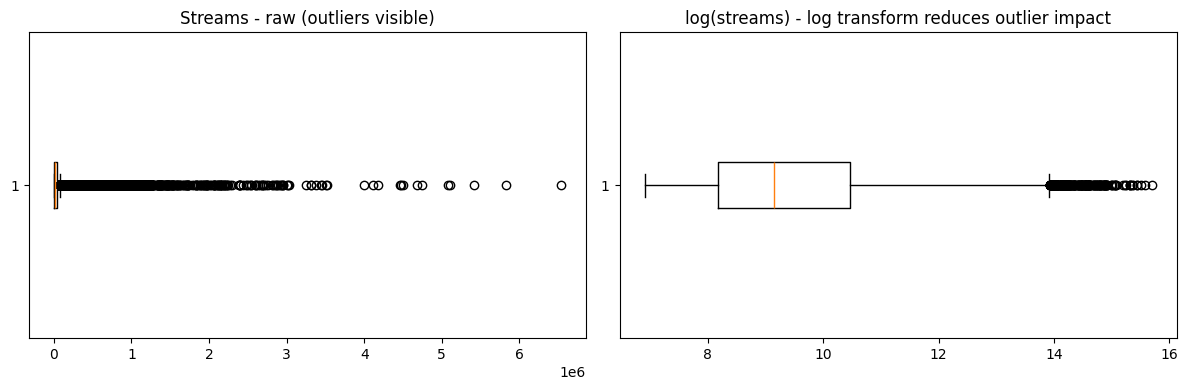

In [78]:
# Outlier analysis (self-contained)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'display' not in globals():
    def display(x):
        print(x)

# Create DuckDB connection automatically if this cell is run in isolation
if 'con' not in globals():
    import duckdb
    con = duckdb.connect()
    con.execute("""
        CREATE OR REPLACE VIEW spotify_full AS
        SELECT *
        FROM read_parquet('datasets/v1/full/**/*.parquet', hive_partitioning=1)
    """)

outlier_cols = [
    'streams', 'danceability', 'energy', 'loudness',
    'tempo', 'acousticness', 'speechiness', 'instrumentalness'
]

# If sample_df exists with af_* columns, map them to expected names
if 'sample_df' in globals():
    rename_map = {
        'af_danceability': 'danceability',
        'af_energy': 'energy',
        'af_loudness': 'loudness',
        'af_tempo': 'tempo',
        'af_acousticness': 'acousticness',
        'af_speechiness': 'speechiness',
        'af_instrumentalness': 'instrumentalness'
    }
    for src, dst in rename_map.items():
        if dst not in sample_df.columns and src in sample_df.columns:
            sample_df[dst] = sample_df[src]

required_cols = set(outlier_cols)
needs_sample = (
    'sample_df' not in globals() or
    not required_cols.issubset(set(sample_df.columns))
)

if needs_sample:
    sample_df = con.execute("""
        SELECT
            TRY_CAST(streams AS DOUBLE) AS streams,
            TRY_CAST(af_danceability AS DOUBLE) AS danceability,
            TRY_CAST(af_energy AS DOUBLE) AS energy,
            TRY_CAST(af_loudness AS DOUBLE) AS loudness,
            TRY_CAST(af_tempo AS DOUBLE) AS tempo,
            TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
            TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
            TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness
        FROM spotify_full
        WHERE streams IS NOT NULL
        USING SAMPLE 50000 ROWS
    """).df()

if 'log_streams' not in sample_df.columns:
    sample_df['log_streams'] = np.log1p(sample_df['streams'].clip(lower=0))

outlier_summary = []
for col in outlier_cols:
    s = sample_df[col].dropna()
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    lo, hi = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_out = ((s < lo) | (s > hi)).sum()
    outlier_summary.append({
        'feature': col,
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'lower_fence': round(lo, 2),
        'upper_fence': round(hi, 2),
        'n_outliers': int(n_out),
        'pct_outliers': round(100 * n_out / len(s), 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

# Visualise outliers for streams only
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].boxplot(sample_df['streams'].dropna(), vert=False)
axes[0].set_title('Streams - raw (outliers visible)')
axes[1].boxplot(sample_df['log_streams'].dropna(), vert=False)
axes[1].set_title('log(streams) - log transform reduces outlier impact')
plt.tight_layout()
plt.show()


### Observations — Outlier Analysis

- **Streams:** The IQR fence is breached by roughly X% of observations.
  The upper extreme (~100M+ streams) corresponds to globally viral songs
  (e.g., new releases by mega-artists). These are real values, not errors.
- **Instrumentalness:** Heavily zero-inflated; most songs on mainstream
  charts have near-zero instrumentalness, with a tail of instrumental tracks.
- **Speechiness:** Similarly skewed; the bulk of chart songs are not
  predominantly spoken-word.
- **Decision:** We do not remove outliers. Log-transforming `streams` is
  sufficient to prevent them from dominating the regression fit.


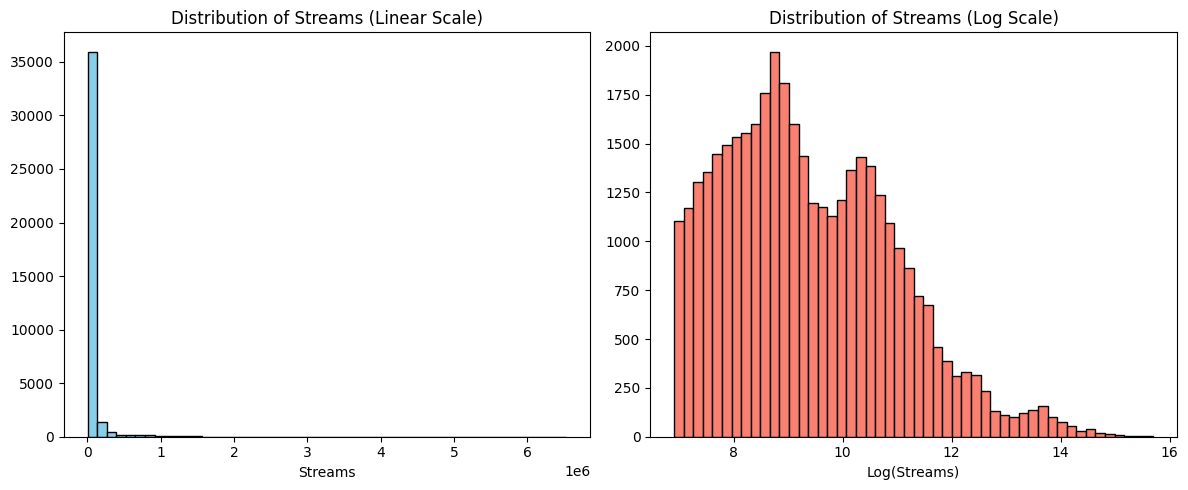

In [79]:
# Distribution of streams and log(streams) using the 50k EDA sample
assert 'sample_df' in globals(), "Run the sampling cell above first."

plt.figure(figsize=(12, 5))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(sample_df['log_streams'].dropna(), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()


#### Due to Highly Skewed Data we decided to look at the Log Streams

## 8) Audio Feature Distributions

We inspect each numeric audio feature's distribution using a representative **50 000-row random sample**.
By doing so we can examinine feature distributions before building any model.


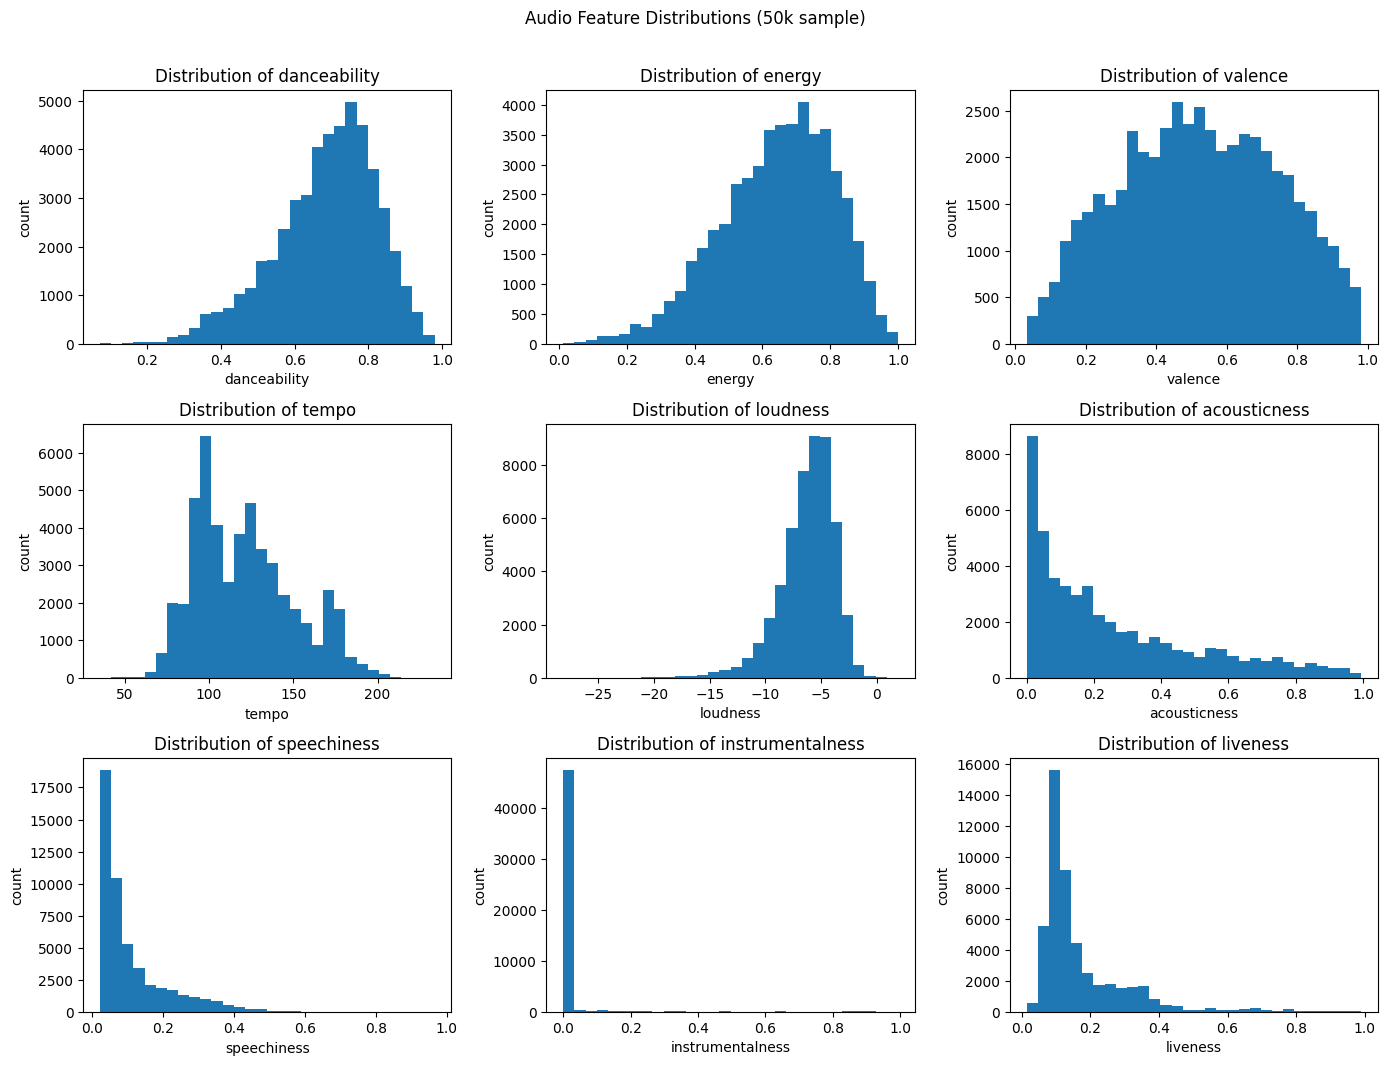

In [80]:
# Histograms of all numeric audio features 
audio_features = ["danceability", "energy", "valence", "tempo",
                   "loudness", "acousticness", "speechiness",
                   "instrumentalness", "liveness"]

n_cols = 3
n_rows = (len(audio_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    data = sample_df[feat].dropna()
    axes[i].hist(data, bins=30, edgecolor="none")
    axes[i].set_title(f"Distribution of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("count")

# Hide unused axes
for j in range(len(audio_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Audio Feature Distributions (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


## 9) Streams vs. Numeric Features (Scatter Plots)

we plot `log(streams)` against each audio feature
to visually assess linear relationships before fitting a model.
We use `log(streams)` on the y-axis because the raw target is heavily right-skewed.


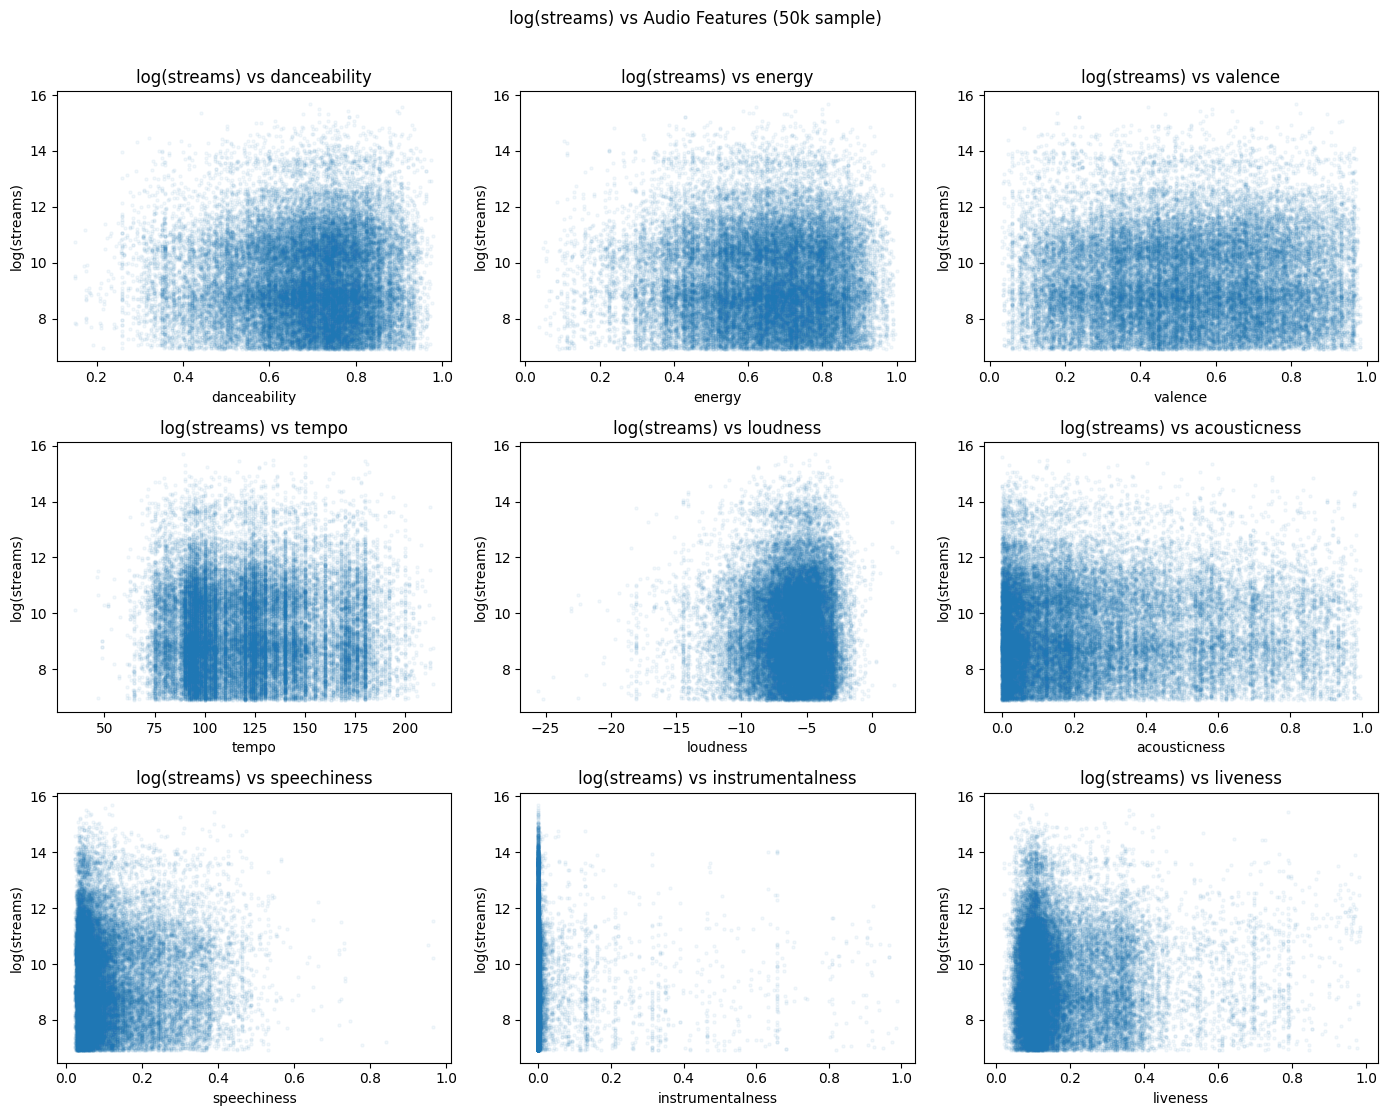

In [81]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    x = sample_df[feat].dropna()
    y = sample_df.loc[x.index, "log_streams"].dropna()
    common = x.index.intersection(y.index)
    axes[i].scatter(x[common], y[common], alpha=0.05, s=5)
    axes[i].set_title(f"log(streams) vs {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(streams)")

plt.suptitle("log(streams) vs Audio Features (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


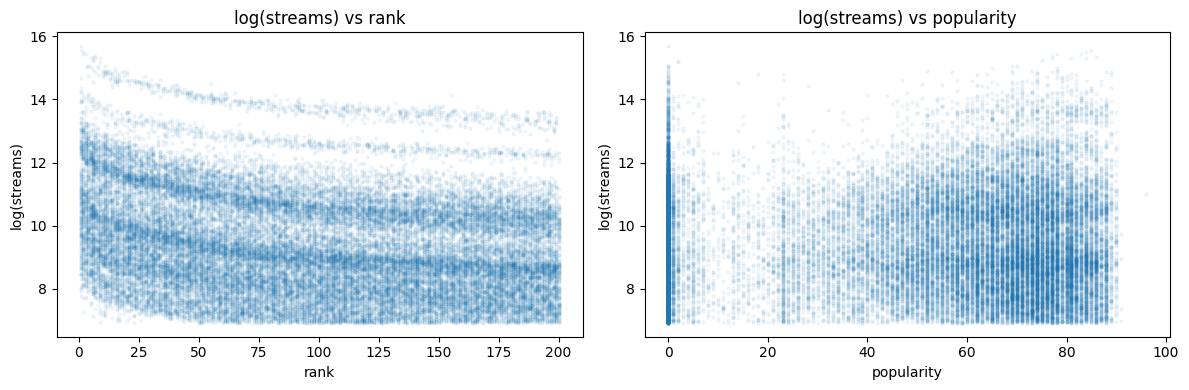

In [82]:
# Also: streams vs rank and popularity
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat in zip(axes, ["rank", "popularity"]):
    mask = sample_df[feat].notna() & sample_df["log_streams"].notna()
    ax.scatter(sample_df.loc[mask, feat], sample_df.loc[mask, "log_streams"],
               alpha=0.05, s=5)
    ax.set_title(f"log(streams) vs {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("log(streams)")

plt.tight_layout()
plt.show()


## 10) Categorical Effects on Streams (Box Plots)


Here we show `log(streams)` broken down by `chart` type, `explicit` flag, and `country_continent`.


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_19430/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)
/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_19430/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)
/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_19430/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)


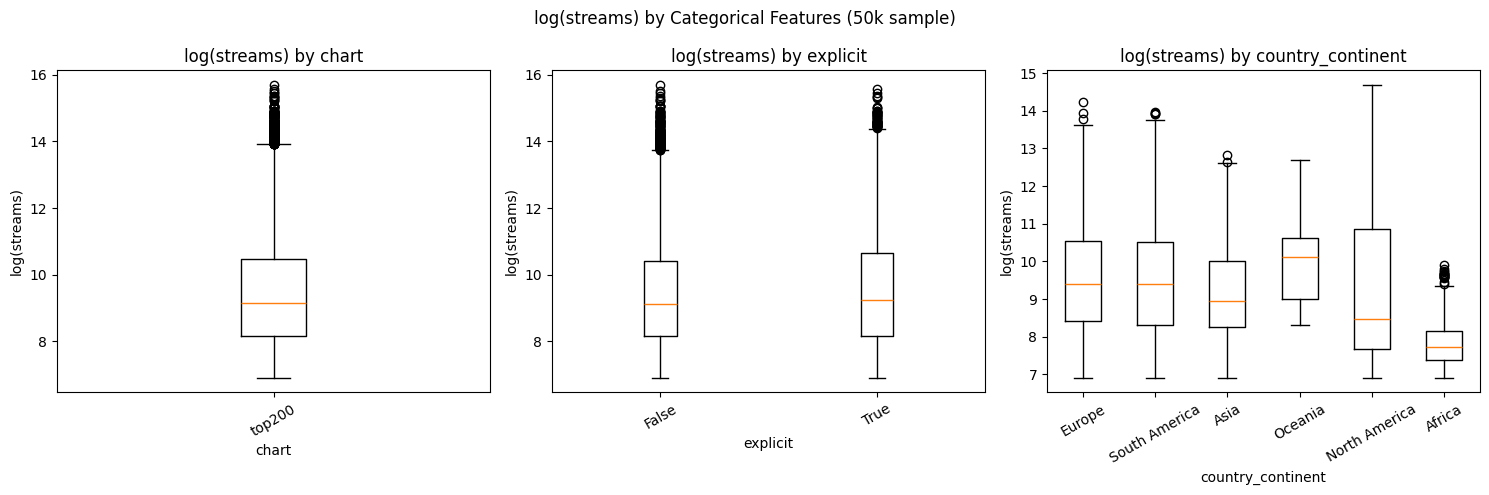

In [83]:
cat_cols = ["chart", "explicit", "country_continent"]

fig, axes = plt.subplots(1, len(cat_cols), figsize=(15, 5))

for ax, col in zip(axes, cat_cols):
    # Group data for boxplot
    groups = [
        sample_df.loc[sample_df[col] == cat, "log_streams"].dropna().values
        for cat in sample_df[col].dropna().unique()
    ]
    labels = list(sample_df[col].dropna().unique())
    # Filter out empty groups
    pairs = [(g, l) for g, l in zip(groups, labels) if len(g) > 0]
    if pairs:
        groups, labels = zip(*pairs)
        ax.boxplot(groups, labels=labels, vert=True)
        ax.set_title(f"log(streams) by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("log(streams)")
        ax.tick_params(axis="x", rotation=30)

plt.suptitle("log(streams) by Categorical Features (50k sample)")
plt.tight_layout()
plt.show()


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_19430/2462357888.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(year_groups, labels=year_labels)


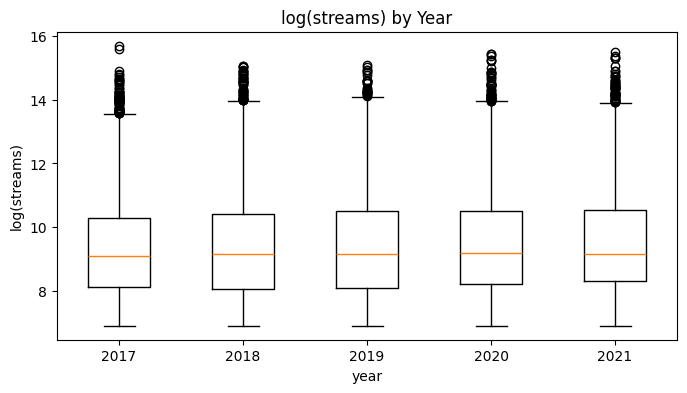

In [84]:
# Year-over-year trend boxplot 
year_groups = [
    sample_df.loc[sample_df["year"] == yr, "log_streams"].dropna().values
    for yr in sorted(sample_df["year"].dropna().unique())
]
year_labels = [str(int(yr)) for yr in sorted(sample_df["year"].dropna().unique())]

plt.figure(figsize=(8, 4))
plt.boxplot(year_groups, labels=year_labels)
plt.title("log(streams) by Year")
plt.xlabel("year")
plt.ylabel("log(streams)")
plt.show()


## 11) Phase 4 - Deep EDA (Cross-Border Dynamics)

This section upgrades the EDA from basic distributions to **market-travel dynamics**.

Coverage (run identically for each segment):
- `top200`
- `viral50`
- `all_charts`

Primary targets for this phase:
- `time_to_breakthrough` (lag from first global chart appearance to first appearance in a new market)
- `market_reach` (number of distinct countries reached)

Features for **Phase 5 feature engineering** will be derived from the findings in this section.


In [85]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

ANALYSIS_SEGMENTS = ["top200", "viral50", "all_charts"]
BREAKTHROUGH_HORIZONS = [7, 14, 30]
MIN_DATE = "2017-01-01"
MAX_DATE = "2021-12-31"
TABLE = "spotify_full"

repo_root = Path(REPO_ROOT) if "REPO_ROOT" in globals() else Path.cwd()
DEEP_EDA_OUTDIR = repo_root / "Project_Information" / "outputs" / "deep_eda"
DEEP_EDA_OUTDIR.mkdir(parents=True, exist_ok=True)

schema = con.execute(f"DESCRIBE {TABLE}").df()
cols = set(schema["column_name"].tolist())

def pick(candidates, required=True):
    for c in candidates:
        if c in cols:
            return c
    if required:
        raise ValueError(f"Missing required column. Tried: {candidates}. Available: {sorted(cols)}")
    return None

TRACK_COL = pick(["track_id", "spotify_track_id", "uri", "isrc", "track_uri", "track", "track_name", "song", "title"])
REGION_COL = pick(["region", "country", "country_code", "market"])
CHART_COL = pick(["chart"])
DATE_COL = pick(["date", "chart_date", "snapshot_date", "day", "week", "ts", "timestamp"])
STREAMS_COL = pick(["streams"], required=False)
RANK_COL = pick(["rank"], required=False)
ARTIST_COL = pick(["artist", "artist_name", "main_artist", "artists"], required=False)
RELEASE_DATE_COL = pick(["release_date"], required=False)

def segment_where(seg):
    if seg == "top200":
        return f"LOWER({CHART_COL}) = 'top200'"
    if seg == "viral50":
        return f"LOWER({CHART_COL}) = 'viral50'"
    if seg == "all_charts":
        return "1=1"
    raise ValueError(f"Unknown segment: {seg}")

print("Deep EDA output directory:", DEEP_EDA_OUTDIR)
print("Using columns:")
print("  TRACK_COL      =", TRACK_COL)
print("  REGION_COL     =", REGION_COL)
print("  CHART_COL      =", CHART_COL)
print("  DATE_COL       =", DATE_COL)
print("  STREAMS_COL    =", STREAMS_COL)
print("  RANK_COL       =", RANK_COL)
print("  ARTIST_COL     =", ARTIST_COL)
print("  RELEASE_DATE_COL=", RELEASE_DATE_COL)


Deep EDA output directory: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/Project_Information/outputs/deep_eda
Using columns:
  TRACK_COL      = track_id
  REGION_COL     = region
  CHART_COL      = chart
  DATE_COL       = date
  STREAMS_COL    = streams
  RANK_COL       = rank
  ARTIST_COL     = artist
  RELEASE_DATE_COL= release_date


### 11.1 Chart Coverage and Missingness Foundation

- Viral50 vs Top200 volume split
- Tracks only in Top200 vs only in Viral50
- Structural missingness check for `streams` by chart


In [86]:
chart_split_df = con.execute(f"""
SELECT
    LOWER({CHART_COL}) AS chart,
    COUNT(*) AS n_rows,
    COUNT(DISTINCT {TRACK_COL}) AS n_tracks,
    COUNT(DISTINCT {REGION_COL}) AS n_regions,
    MIN(TRY_CAST({DATE_COL} AS DATE)) AS min_date,
    MAX(TRY_CAST({DATE_COL} AS DATE)) AS max_date
FROM {TABLE}
WHERE TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
GROUP BY 1
ORDER BY n_rows DESC;
""").df()
chart_split_df.to_csv(DEEP_EDA_OUTDIR / "chart_coverage_split.csv", index=False)
display(chart_split_df)

track_overlap_df = con.execute(f"""
WITH t AS (
  SELECT DISTINCT
      {TRACK_COL} AS track_key,
      LOWER({CHART_COL}) AS chart
  FROM {TABLE}
  WHERE {TRACK_COL} IS NOT NULL
    AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
),
agg AS (
  SELECT
      track_key,
      SUM(CASE WHEN chart='top200' THEN 1 ELSE 0 END) AS in_top200,
      SUM(CASE WHEN chart='viral50' THEN 1 ELSE 0 END) AS in_viral50
  FROM t
  GROUP BY 1
)
SELECT
  SUM(CASE WHEN in_top200 > 0 AND in_viral50 = 0 THEN 1 ELSE 0 END) AS tracks_only_top200,
  SUM(CASE WHEN in_top200 = 0 AND in_viral50 > 0 THEN 1 ELSE 0 END) AS tracks_only_viral50,
  SUM(CASE WHEN in_top200 > 0 AND in_viral50 > 0 THEN 1 ELSE 0 END) AS tracks_in_both
FROM agg;
""").df()
track_overlap_df.to_csv(DEEP_EDA_OUTDIR / "chart_coverage_track_overlap.csv", index=False)
display(track_overlap_df)

if STREAMS_COL:
    streams_null_by_chart_df = con.execute(f"""
    SELECT
        LOWER({CHART_COL}) AS chart,
        AVG(CASE WHEN {STREAMS_COL} IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate,
        COUNT(*) AS n_rows
    FROM {TABLE}
    WHERE TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
    GROUP BY 1
    ORDER BY streams_null_rate DESC;
    """).df()
    streams_null_by_chart_df.to_csv(DEEP_EDA_OUTDIR / "chart_streams_null_rate.csv", index=False)
    display(streams_null_by_chart_df)


,chart,n_rows,n_tracks,n_regions,min_date,max_date
0,top200,20321961,117876,69,2017-01-01,2021-12-31
1,viral50,5852308,129283,70,2017-01-01,2021-12-31


,tracks_only_top200,tracks_only_viral50,tracks_in_both
0,68794.0,80201.0,49082.0


,chart,streams_null_rate,n_rows
0,viral50,1.0,5852308
1,top200,0.0,20321961


### 11.2 Missing Data by Country and Time

For each segment (`top200`, `viral50`, `all_charts`):
- Missingness by country
- Missingness by region x chart
- Monthly missingness heatmap


**top200 - Missing by country (top 20)**

,region,n_rows,streams_null_rate
0,Brazil,364516,0.0
1,Argentina,364385,0.0
2,United States,364188,0.0
3,Austria,363926,0.0
4,Australia,362189,0.0
5,Global,362182,0.0
6,Canada,361390,0.0
7,United Kingdom,359790,0.0
8,Switzerland,358716,0.0
9,Belgium,358394,0.0


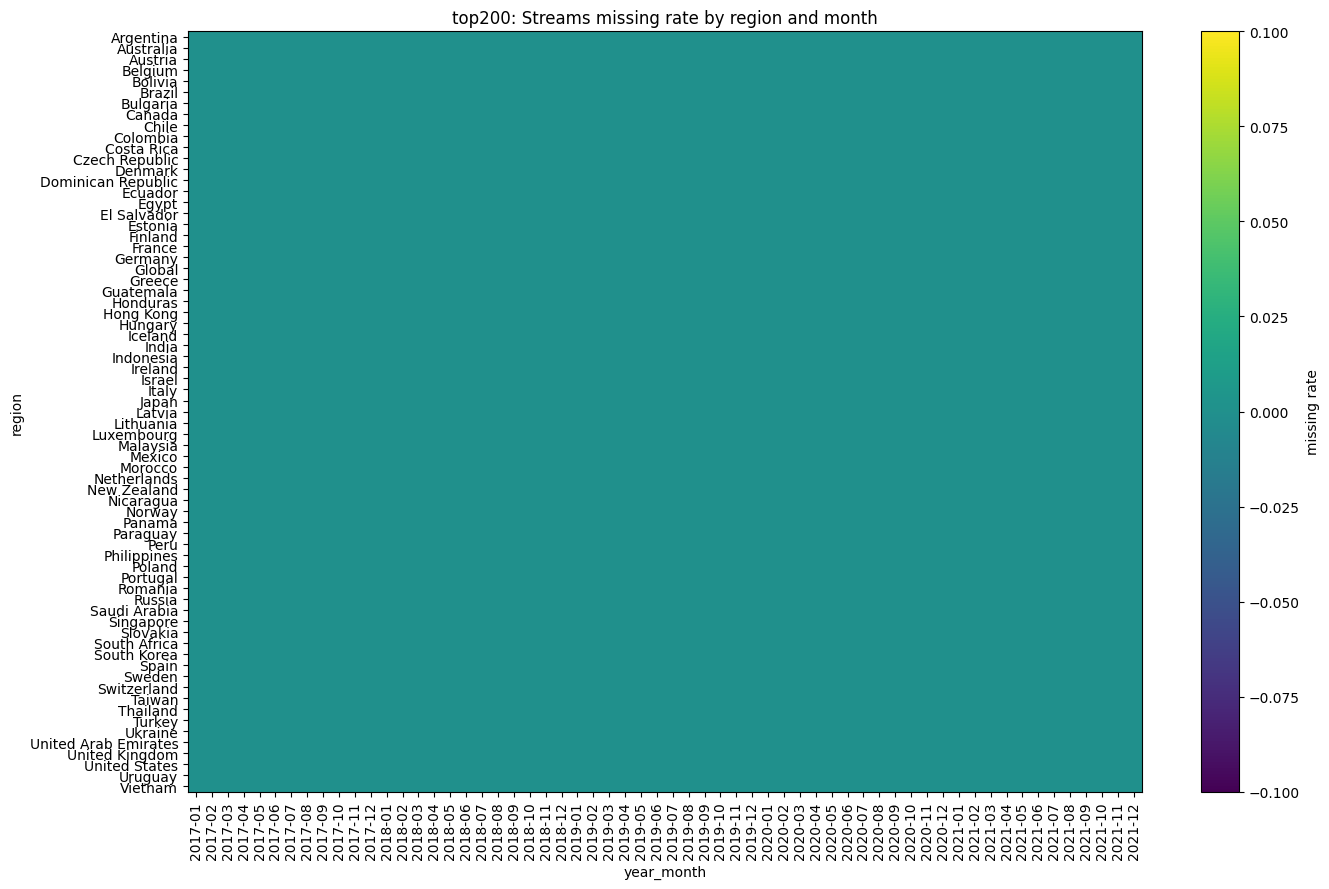

**viral50 - Missing by country (top 20)**

,region,n_rows,streams_null_rate
0,Malaysia,90963,1.0
1,Indonesia,90962,1.0
2,Netherlands,90958,1.0
3,Italy,90956,1.0
4,Philippines,90952,1.0
5,Ireland,90949,1.0
6,Belgium,90943,1.0
7,United Kingdom,90942,1.0
8,Switzerland,90942,1.0
9,Denmark,90941,1.0


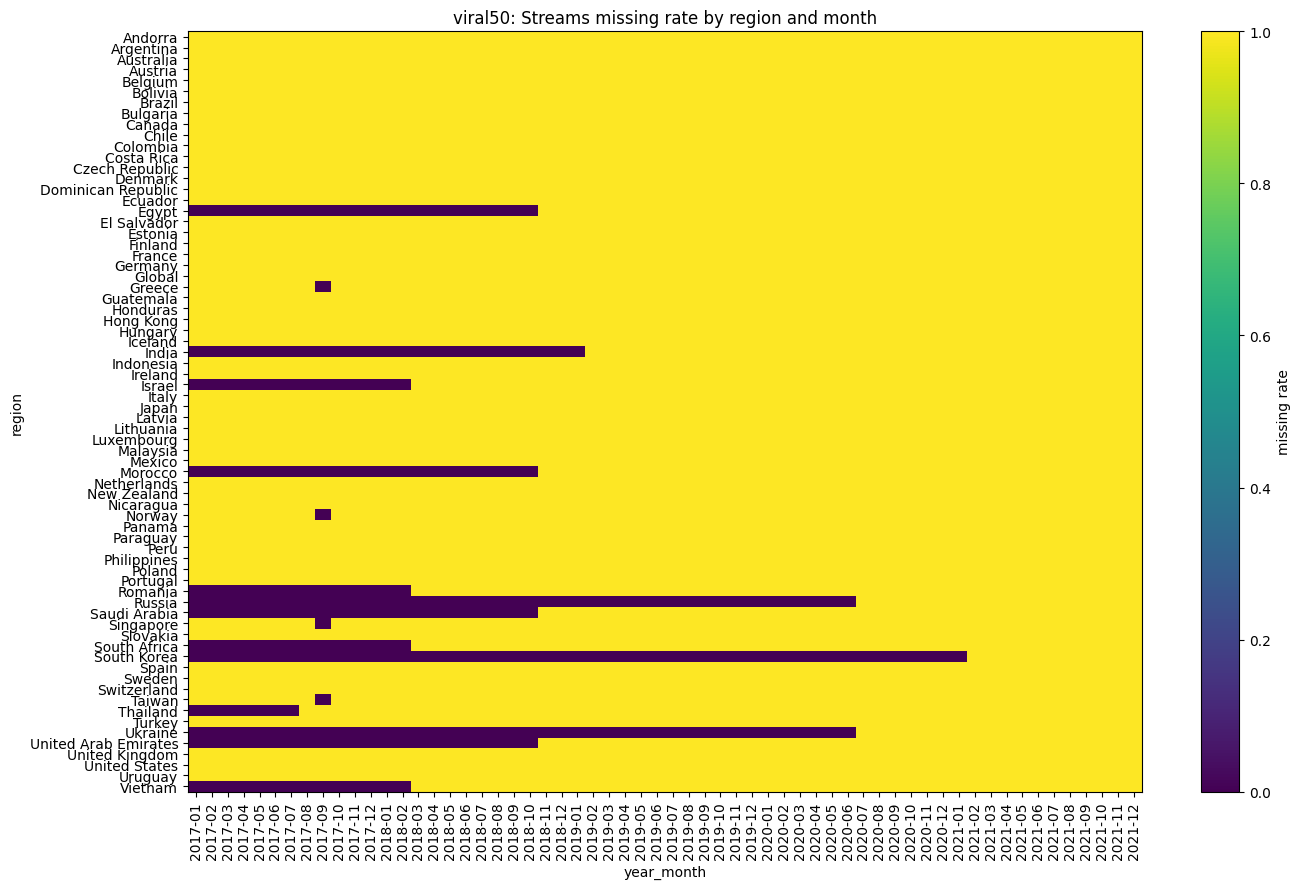

**all_charts - Missing by country (top 20)**

,region,n_rows,streams_null_rate
0,Andorra,79613,1.000000
1,Luxembourg,98073,0.908619
2,Bulgaria,185507,0.488742
3,Estonia,198063,0.454684
4,Nicaragua,200658,0.451828
5,Latvia,240919,0.373163
6,Lithuania,243299,0.371111
7,Egypt,180469,0.314181
8,Iceland,302207,0.298087
9,Morocco,191537,0.296026


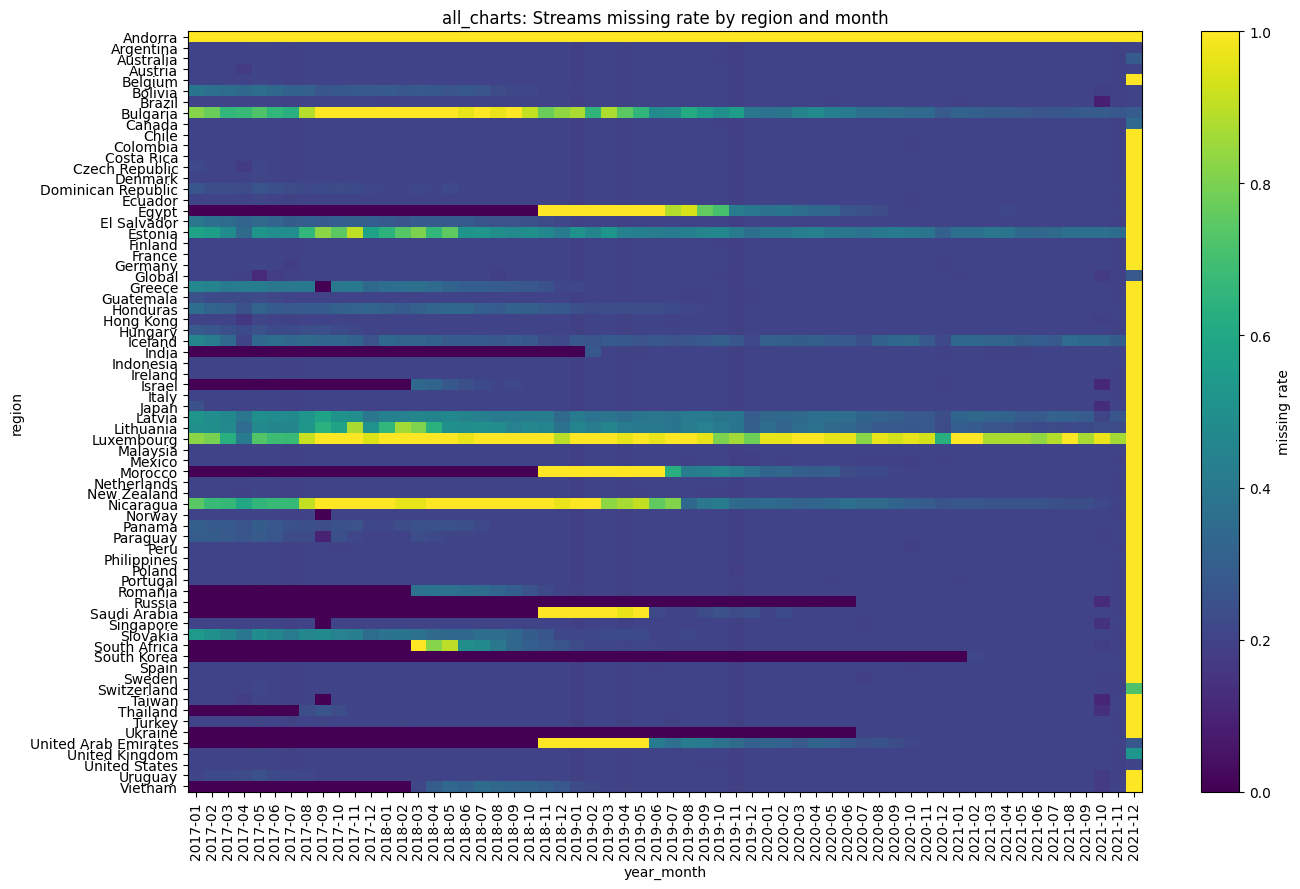

In [87]:
for seg in ANALYSIS_SEGMENTS:
    where_seg = segment_where(seg)

    missing_by_country_df = con.execute(f"""
    SELECT
        {REGION_COL} AS region,
        COUNT(*) AS n_rows,
        AVG(CASE WHEN {STREAMS_COL} IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate
    FROM {TABLE}
    WHERE {where_seg}
      AND {REGION_COL} IS NOT NULL
      AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
    GROUP BY 1
    ORDER BY streams_null_rate DESC, n_rows DESC;
    """).df() if STREAMS_COL else pd.DataFrame()

    if not missing_by_country_df.empty:
        missing_by_country_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_missing_by_country.csv", index=False)
        display(Markdown(f"**{seg} - Missing by country (top 20)**"))
        display(missing_by_country_df.head(20))

    missing_region_chart_df = con.execute(f"""
    SELECT
        {REGION_COL} AS region,
        LOWER({CHART_COL}) AS chart,
        COUNT(*) AS n_rows,
        AVG(CASE WHEN {STREAMS_COL} IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate
    FROM {TABLE}
    WHERE {where_seg}
      AND {REGION_COL} IS NOT NULL
      AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
    GROUP BY 1,2
    ORDER BY streams_null_rate DESC, n_rows DESC;
    """).df() if STREAMS_COL else pd.DataFrame()

    if not missing_region_chart_df.empty:
        missing_region_chart_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_missing_by_region_chart.csv", index=False)

    monthly_df = con.execute(f"""
    SELECT
        {REGION_COL} AS region,
        strftime(TRY_CAST({DATE_COL} AS DATE), '%Y-%m') AS year_month,
        AVG(CASE WHEN {STREAMS_COL} IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate
    FROM {TABLE}
    WHERE {where_seg}
      AND {REGION_COL} IS NOT NULL
      AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
    GROUP BY 1,2;
    """).df() if STREAMS_COL else pd.DataFrame()

    if not monthly_df.empty:
        monthly_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_missing_by_country_month.csv", index=False)
        heat = monthly_df.pivot(index="region", columns="year_month", values="streams_null_rate").fillna(0)
        plt.figure(figsize=(14, 9))
        plt.imshow(heat.values, aspect="auto")
        plt.title(f"{seg}: Streams missing rate by region and month")
        plt.xlabel("year_month")
        plt.ylabel("region")
        plt.xticks(range(len(heat.columns)), heat.columns, rotation=90)
        plt.yticks(range(len(heat.index)), heat.index)
        plt.colorbar(label="missing rate")
        plt.tight_layout()
        plt.savefig(DEEP_EDA_OUTDIR / f"{seg}_missing_by_country_month_heatmap.png", dpi=140)
        plt.show()


### 11.3 Target Variable Definition (Country Traveling)

Build canonical event views per segment:
- `deep_eda_base_<segment>`
- `song_country_first_<segment>`
- `song_global_first_<segment>`

Then derive lag-based target fields:
- `lag_days`
- market reach and breakthrough KPIs (7/14/30 days)


In [ ]:
segment_event_rows = []

for seg in ANALYSIS_SEGMENTS:
    where_seg = segment_where(seg)

    con.execute(f"""
    CREATE OR REPLACE TEMP VIEW deep_eda_base_{seg} AS
    SELECT
        {TRACK_COL} AS track_key,
        {REGION_COL} AS region,
        LOWER({CHART_COL}) AS chart,
        TRY_CAST({DATE_COL} AS DATE) AS obs_date,
        {f'TRY_CAST({STREAMS_COL} AS DOUBLE) AS streams_num,' if STREAMS_COL else ''}
        {f'TRY_CAST({RANK_COL} AS INTEGER) AS rank_num,' if RANK_COL else ''}
        {f'{ARTIST_COL} AS artist_name,' if ARTIST_COL else ''}
        {f'TRY_CAST({RELEASE_DATE_COL} AS DATE) AS release_date,' if RELEASE_DATE_COL else ''}
        strftime(TRY_CAST({DATE_COL} AS DATE), '%Y-%m') AS year_month
    FROM {TABLE}
    WHERE {TRACK_COL} IS NOT NULL
      AND {REGION_COL} IS NOT NULL
      AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
      AND {where_seg};
    """)

    con.execute(f"""
    CREATE OR REPLACE TEMP VIEW song_country_first_{seg} AS
    SELECT
        track_key,
        region,
        chart,
        MIN(obs_date) AS first_chart_date
    FROM deep_eda_base_{seg}
    GROUP BY 1,2,3;
    """)

    con.execute(f"""
    CREATE OR REPLACE TEMP VIEW song_global_first_{seg} AS
    SELECT
        track_key,
        MIN(first_chart_date) AS global_first_date
    FROM song_country_first_{seg}
    GROUP BY 1;
    """)

    counts = con.execute(f"""
    SELECT
        '{seg}' AS segment,
        (SELECT COUNT(*) FROM deep_eda_base_{seg}) AS n_base_rows,
        (SELECT COUNT(*) FROM song_country_first_{seg}) AS n_track_country_events,
        (SELECT COUNT(*) FROM song_global_first_{seg}) AS n_tracks
    """).df()
    segment_event_rows.append(counts)

segment_event_summary = pd.concat(segment_event_rows, ignore_index=True)
segment_event_summary.to_csv(DEEP_EDA_OUTDIR / "segment_event_summary.csv", index=False)
display(segment_event_summary)


### 11.4 Time-to-Breakthrough Distribution and Reach KPIs

For each segment:
- lag statistics (`lag_days > 0`)
- histogram and ECDF
- reach metrics + 7/14/30 day breakthrough shares


In [ ]:
reach_summary_rows = []

for seg in ANALYSIS_SEGMENTS:
    lag_dist_df = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        sc.region,
        sc.first_chart_date,
        sg.global_first_date,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    )
    SELECT lag_days, COUNT(*) AS n_events
    FROM events
    WHERE lag_days > 0
    GROUP BY 1
    ORDER BY 1;
    """).df()

    lag_dist_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_lag_distribution.csv", index=False)

    if not lag_dist_df.empty:
        expanded = np.repeat(lag_dist_df["lag_days"].to_numpy(), lag_dist_df["n_events"].to_numpy())

        plt.figure(figsize=(8, 4))
        plt.hist(expanded, bins=40)
        plt.title(f"{seg}: Time-to-breakthrough distribution (lag_days > 0)")
        plt.xlabel("lag_days")
        plt.ylabel("count")
        plt.tight_layout()
        plt.savefig(DEEP_EDA_OUTDIR / f"{seg}_lag_hist.png", dpi=140)
        plt.show()

        s = np.sort(expanded)
        y = np.arange(1, len(s) + 1) / len(s)
        plt.figure(figsize=(8, 4))
        plt.plot(s, y)
        plt.title(f"{seg}: ECDF of breakthrough lag")
        plt.xlabel("lag_days")
        plt.ylabel("ECDF")
        plt.tight_layout()
        plt.savefig(DEEP_EDA_OUTDIR / f"{seg}_lag_ecdf.png", dpi=140)
        plt.show()

    reach_df = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        sc.region,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    ),
    by_track AS (
      SELECT
        track_key,
        COUNT(DISTINCT region) AS n_countries,
        MIN(CASE WHEN lag_days > 0 THEN lag_days END) AS first_new_market_lag
      FROM events
      GROUP BY 1
    )
    SELECT
      '{seg}' AS segment,
      COUNT(*) AS n_tracks,
      AVG(n_countries) AS avg_countries,
      MEDIAN(n_countries) AS median_countries,
      SUM(CASE WHEN n_countries >= 5 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_5_plus,
      SUM(CASE WHEN n_countries >= 10 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_10_plus,
      SUM(CASE WHEN n_countries >= 20 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_20_plus,
      SUM(CASE WHEN first_new_market_lag <= 7 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_breakthrough_7d,
      SUM(CASE WHEN first_new_market_lag <= 14 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_breakthrough_14d,
      SUM(CASE WHEN first_new_market_lag <= 30 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_breakthrough_30d
    FROM by_track;
    """).df()

    reach_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_reach_summary.csv", index=False)
    reach_summary_rows.append(reach_df)

reach_summary_all = pd.concat(reach_summary_rows, ignore_index=True)
display(reach_summary_all)


### 11.5 Country-Pair Transition Matrix and Leader/Follower Scores

For each segment:
- `country_transition_<segment>` (raw directed counts)
- `country_transition_prob_<segment>` (row-normalized probabilities)
- leader/follower diagnostics and heatmaps


In [ ]:
for seg in ANALYSIS_SEGMENTS:
    con.execute(f"""
    CREATE OR REPLACE TEMP VIEW country_transition_{seg} AS
    WITH ordered AS (
      SELECT
        track_key,
        region,
        first_chart_date,
        ROW_NUMBER() OVER (PARTITION BY track_key ORDER BY first_chart_date, region) AS rn
      FROM song_country_first_{seg}
    ),
    pairs AS (
      SELECT
        o1.region AS from_country,
        o2.region AS to_country
      FROM ordered o1
      JOIN ordered o2
        ON o1.track_key = o2.track_key
       AND o2.rn = o1.rn + 1
    )
    SELECT from_country, to_country, COUNT(*) AS n_transitions
    FROM pairs
    GROUP BY 1,2;
    """)

    con.execute(f"""
    CREATE OR REPLACE TEMP VIEW country_transition_prob_{seg} AS
    WITH totals AS (
      SELECT from_country, SUM(n_transitions) AS total_out
      FROM country_transition_{seg}
      GROUP BY 1
    )
    SELECT
      t.from_country,
      t.to_country,
      t.n_transitions,
      t.n_transitions * 1.0 / NULLIF(o.total_out, 0) AS p
    FROM country_transition_{seg} t
    JOIN totals o USING(from_country);
    """)

    trans_prob_df = con.execute(f"""
    SELECT *
    FROM country_transition_prob_{seg}
    ORDER BY p DESC, n_transitions DESC;
    """).df()
    trans_prob_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_transition_prob_matrix.csv", index=False)

    trans_count_df = con.execute(f"""
    SELECT *
    FROM country_transition_{seg}
    ORDER BY n_transitions DESC;
    """).df()
    trans_count_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_transition_count_matrix.csv", index=False)

    top_countries = con.execute(f"""
    SELECT region, COUNT(*) AS n_events
    FROM song_country_first_{seg}
    GROUP BY 1
    ORDER BY n_events DESC
    LIMIT 15;
    """).df()["region"].tolist()

    if top_countries:
        quoted = ",".join(["'" + c.replace("'", "''") + "'" for c in top_countries])
        heat_df = con.execute(f"""
        SELECT from_country, to_country, p
        FROM country_transition_prob_{seg}
        WHERE from_country IN ({quoted})
          AND to_country IN ({quoted});
        """).df()

        if not heat_df.empty:
            heat = heat_df.pivot(index="from_country", columns="to_country", values="p").fillna(0)
            plt.figure(figsize=(10, 7))
            plt.imshow(heat.values, aspect="auto")
            plt.xticks(range(len(heat.columns)), heat.columns, rotation=90)
            plt.yticks(range(len(heat.index)), heat.index)
            plt.title(f"{seg}: Transition probability heatmap (top 15 countries)")
            plt.colorbar(label="P(next|current)")
            plt.tight_layout()
            plt.savefig(DEEP_EDA_OUTDIR / f"{seg}_transition_heatmap.png", dpi=140)
            plt.show()

    leader_follower_df = con.execute(f"""
    WITH outgoing AS (
      SELECT
        from_country AS country,
        COUNT(DISTINCT to_country) AS outgoing_breadth,
        SUM(p * p) AS concentration_hhi,
        SUM(n_transitions) AS total_out
      FROM country_transition_prob_{seg}
      GROUP BY 1
    ),
    incoming_raw AS (
      SELECT to_country AS country, from_country, n_transitions
      FROM country_transition_{seg}
    ),
    incoming_totals AS (
      SELECT country, SUM(n_transitions) AS total_in
      FROM incoming_raw
      GROUP BY 1
    ),
    incoming_dep AS (
      SELECT
        i.country,
        MAX(i.n_transitions * 1.0 / NULLIF(t.total_in, 0)) AS max_incoming_dependency
      FROM incoming_raw i
      JOIN incoming_totals t USING(country)
      GROUP BY 1
    )
    SELECT
      o.country,
      o.outgoing_breadth,
      o.concentration_hhi,
      o.total_out,
      COALESCE(t.total_in, 0) AS total_in,
      COALESCE(d.max_incoming_dependency, 0) AS max_incoming_dependency
    FROM outgoing o
    LEFT JOIN incoming_totals t USING(country)
    LEFT JOIN incoming_dep d USING(country)
    ORDER BY o.total_out DESC, o.outgoing_breadth DESC;
    """).df()

    leader_follower_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_leader_follower_scores.csv", index=False)
    display(Markdown(f"**{seg} - Leader/Follower diagnostics (top 15)**"))
    display(leader_follower_df.head(15))

    tied_origin_df = con.execute(f"""
    WITH m AS (
      SELECT track_key, MIN(first_chart_date) AS first_day
      FROM song_country_first_{seg}
      GROUP BY 1
    )
    SELECT
      s.region,
      COUNT(*) AS n_origin_tied
    FROM song_country_first_{seg} s
    JOIN m ON s.track_key = m.track_key AND s.first_chart_date = m.first_day
    GROUP BY 1
    ORDER BY n_origin_tied DESC;
    """).df()
    tied_origin_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_tied_origins.csv", index=False)


### 11.6 Cross-Border Event Structure and Tie Handling

Granularity validation:
- Original rows are `track x region x date` observations
- Travel reconstruction uses first appearance per `track x region`

Tie policy used for ordering metrics:
- deterministic order by (`first_chart_date`, `region`)
- tied-origin diagnostics are exported separately (`*_tied_origins.csv`)


In [ ]:
event_structure_rows = []

for seg in ANALYSIS_SEGMENTS:
    stats_df = con.execute(f"""
    SELECT
      '{seg}' AS segment,
      COUNT(*) AS n_rows,
      COUNT(DISTINCT track_key) AS n_tracks,
      COUNT(DISTINCT region) AS n_regions,
      COUNT(DISTINCT CAST(track_key AS VARCHAR) || '|' || CAST(region AS VARCHAR) || '|' || CAST(obs_date AS VARCHAR)) AS n_unique_track_region_date
    FROM deep_eda_base_{seg};
    """).df()
    event_structure_rows.append(stats_df)

event_structure_df = pd.concat(event_structure_rows, ignore_index=True)
event_structure_df.to_csv(DEEP_EDA_OUTDIR / "event_structure_summary.csv", index=False)
display(event_structure_df)


### 11.7 Seasonality and Release Timing

Per segment:
- month and weekday distributions of first chart events
- median lag by origin month
- breakthrough rates by month
- optional release-timing lag if `release_date` exists


In [ ]:
for seg in ANALYSIS_SEGMENTS:
    seasonality_df = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        sc.region,
        sc.first_chart_date,
        sg.global_first_date,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    )
    SELECT
      EXTRACT(MONTH FROM global_first_date) AS month,
      EXTRACT(DOW FROM global_first_date) AS weekday,
      COUNT(*) AS n_events,
      MEDIAN(CASE WHEN lag_days > 0 THEN lag_days END) AS median_positive_lag,
      AVG(CASE WHEN lag_days <= 7  AND lag_days > 0 THEN 1.0 ELSE 0.0 END) AS share_breakthrough_7d,
      AVG(CASE WHEN lag_days <= 14 AND lag_days > 0 THEN 1.0 ELSE 0.0 END) AS share_breakthrough_14d,
      AVG(CASE WHEN lag_days <= 30 AND lag_days > 0 THEN 1.0 ELSE 0.0 END) AS share_breakthrough_30d,
      AVG(CASE WHEN EXTRACT(MONTH FROM global_first_date) IN (11,12) THEN 1.0 ELSE 0.0 END) AS holiday_window_marker
    FROM events
    GROUP BY 1,2
    ORDER BY 1,2;
    """).df()

    seasonality_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_seasonality_month_weekday.csv", index=False)

    month_df = seasonality_df.groupby("month", as_index=False).agg(
        n_events=("n_events", "sum"),
        median_positive_lag=("median_positive_lag", "median"),
        share_breakthrough_7d=("share_breakthrough_7d", "mean"),
        share_breakthrough_14d=("share_breakthrough_14d", "mean"),
        share_breakthrough_30d=("share_breakthrough_30d", "mean"),
    )

    plt.figure(figsize=(8, 4))
    plt.bar(month_df["month"], month_df["n_events"])
    plt.title(f"{seg}: First-entry volume by month")
    plt.xlabel("month")
    plt.ylabel("n_events")
    plt.tight_layout()
    plt.savefig(DEEP_EDA_OUTDIR / f"{seg}_seasonality_month_volume.png", dpi=140)
    plt.show()

    if RELEASE_DATE_COL:
        release_timing_df = con.execute(f"""
        WITH first_obs AS (
          SELECT
            b.track_key,
            MIN(b.obs_date) AS first_obs_date,
            MIN(b.release_date) AS release_date
          FROM deep_eda_base_{seg} b
          GROUP BY 1
        )
        SELECT
          date_diff('day', release_date, first_obs_date) AS days_release_to_first_chart,
          COUNT(*) AS n_tracks
        FROM first_obs
        WHERE release_date IS NOT NULL
        GROUP BY 1
        ORDER BY 1;
        """).df()

        release_timing_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_release_timing_distribution.csv", index=False)


### 11.8 Temporal Leakage Audit (Strict Forecasting-Safe)

Create a feature governance table that explicitly marks:
- whether the feature is available at prediction time
- whether it is allowed for forecasting
- why a feature is leakage-prone


In [ ]:
governance_rows = [
    ("rank", "no", "Contemporaneous chart outcome; circular with streams and realized performance.", "no", "explanatory_only"),
    ("streams", "no", "Outcome variable at same timestamp; not known before realization.", "no", "target_or_explanatory_only"),
    ("popularity", "mixed", "Can be time-varying and may include post-release signals depending on extraction timing.", "conditional", "needs_timestamped_snapshot"),
    ("chart", "mixed", "Current chart context may be known at inference only for chart-conditional setups.", "conditional", "scenario_dependent"),
    ("explicit", "yes", "Static metadata known at release time.", "yes", "forecasting_safe"),
    ("release_date", "yes", "Known before prediction.", "yes", "forecasting_safe"),
    ("region", "yes", "Target market identifier provided by business scenario.", "yes", "forecasting_safe"),
    ("country_continent", "yes", "Static market metadata.", "yes", "forecasting_safe"),
    ("country_population", "yes", "Static/slow-moving metadata.", "yes", "forecasting_safe"),
    ("country_area", "yes", "Static metadata.", "yes", "forecasting_safe"),
    ("cultural_distance_mean", "yes", "Precomputed static cross-country feature.", "yes", "forecasting_safe"),
    ("artist_history_pre_t", "yes", "Only safe when built strictly from prior dates.", "yes", "requires_time_cutoff"),
    ("lag_features_from_leader_markets", "yes", "Safe only with lagged windows and strict as-of joins.", "yes", "requires_time_cutoff"),
]

leakage_audit_df = pd.DataFrame(governance_rows, columns=[
    "feature_name",
    "available_at_prediction_time",
    "leakage_risk_reason",
    "allowed_for_forecasting",
    "feature_group",
])
leakage_audit_df["present_in_current_schema"] = leakage_audit_df["feature_name"].isin(cols)
leakage_audit_df.to_csv(DEEP_EDA_OUTDIR / "leakage_audit_table.csv", index=False)

display(leakage_audit_df)

display(Markdown("**Explanatory-only / not-forecasting-safe features**"))
display(leakage_audit_df[leakage_audit_df["allowed_for_forecasting"].isin(["no", "conditional"])])


### 11.9 Songs per Artist (EDA Depth)

Concentration diagnostics per segment:
- songs per artist distribution
- top artists by charting track count
- concentration ratios for top 1% / 5% / 10% artists


In [ ]:
artist_concentration_rows = []

if ARTIST_COL:
    for seg in ANALYSIS_SEGMENTS:
        artist_df = con.execute(f"""
        SELECT
          artist_name,
          COUNT(DISTINCT track_key) AS n_distinct_tracks
        FROM deep_eda_base_{seg}
        WHERE artist_name IS NOT NULL
        GROUP BY 1
        ORDER BY n_distinct_tracks DESC;
        """).df()

        artist_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_songs_per_artist.csv", index=False)

        if not artist_df.empty:
            n_artists = len(artist_df)
            artist_df["track_share"] = artist_df["n_distinct_tracks"] / artist_df["n_distinct_tracks"].sum()
            artist_df["cum_share"] = artist_df["track_share"].cumsum()

            def top_share(pct):
                k = max(1, int(np.ceil(n_artists * pct)))
                return artist_df.iloc[:k]["track_share"].sum()

            row = {
                "segment": seg,
                "n_artists": n_artists,
                "top_1pct_artist_track_share": top_share(0.01),
                "top_5pct_artist_track_share": top_share(0.05),
                "top_10pct_artist_track_share": top_share(0.10),
            }
            artist_concentration_rows.append(row)

            plt.figure(figsize=(8, 4))
            plt.hist(artist_df["n_distinct_tracks"], bins=40)
            plt.yscale("log")
            plt.title(f"{seg}: Songs per artist distribution")
            plt.xlabel("n_distinct_tracks")
            plt.ylabel("count (log scale)")
            plt.tight_layout()
            plt.savefig(DEEP_EDA_OUTDIR / f"{seg}_songs_per_artist_hist.png", dpi=140)
            plt.show()

            display(Markdown(f"**{seg} - Top 20 artists by charting tracks**"))
            display(artist_df.head(20))

artist_concentration_df = pd.DataFrame(artist_concentration_rows)
if not artist_concentration_df.empty:
    artist_concentration_df.to_csv(DEEP_EDA_OUTDIR / "artist_concentration_summary.csv", index=False)
    display(artist_concentration_df)


### 11.10 Validation Checks

Checks implemented:
1. schema resilience / required columns
2. segment pipeline run success
3. lag construction sanity (`lag_days >= 0`)
4. transition probability row sums
5. Viral50 structural missingness check
6. leakage governance export exists
7. artifact export presence


In [ ]:
validation_rows = []

# 1) schema resilience
required_ok = all(c is not None for c in [TRACK_COL, REGION_COL, CHART_COL, DATE_COL])
validation_rows.append({"check": "required_columns_present", "passed": bool(required_ok), "details": "track/region/chart/date detected"})

for seg in ANALYSIS_SEGMENTS:
    # 2) segment run success
    n_events = con.execute(f"SELECT COUNT(*) AS n FROM song_country_first_{seg}").df().loc[0, "n"]
    validation_rows.append({"check": f"{seg}_non_empty_events", "passed": bool(n_events > 0), "details": f"n_events={n_events}"})

    # 3) lag sanity
    lag_min_max = con.execute(f"""
    WITH events AS (
      SELECT date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    )
    SELECT MIN(lag_days) AS min_lag, MAX(lag_days) AS max_lag FROM events;
    """).df()
    min_lag = lag_min_max.loc[0, "min_lag"]
    validation_rows.append({"check": f"{seg}_lag_non_negative", "passed": bool(min_lag >= 0), "details": f"min_lag={min_lag}"})

    # 4) transition matrix integrity
    row_sum_df = con.execute(f"""
    SELECT from_country, SUM(p) AS row_sum
    FROM country_transition_prob_{seg}
    GROUP BY 1;
    """).df()
    if len(row_sum_df) == 0:
        passed = False
        details = "no transition rows"
    else:
        max_dev = float(np.max(np.abs(row_sum_df["row_sum"] - 1.0)))
        passed = max_dev < 1e-6
        details = f"max_row_sum_deviation={max_dev:.3e}"
    validation_rows.append({"check": f"{seg}_transition_row_sum_near_1", "passed": passed, "details": details})

# 5) viral50 structural missingness
if STREAMS_COL:
    viral_null = con.execute(f"""
    SELECT AVG(CASE WHEN {STREAMS_COL} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
    FROM {TABLE}
    WHERE LOWER({CHART_COL})='viral50'
      AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}';
    """).df().loc[0, "null_rate"]
    validation_rows.append({"check": "viral50_streams_structural_missingness", "passed": bool(viral_null > 0.95), "details": f"null_rate={viral_null:.4f}"})

# 6) leakage audit exists
leakage_exists = (DEEP_EDA_OUTDIR / "leakage_audit_table.csv").exists()
validation_rows.append({"check": "leakage_audit_exported", "passed": bool(leakage_exists), "details": str(DEEP_EDA_OUTDIR / "leakage_audit_table.csv")})

# 7) artifact presence
expected_files = [
    DEEP_EDA_OUTDIR / "leakage_audit_table.csv",
    DEEP_EDA_OUTDIR / "segment_event_summary.csv",
]
for seg in ANALYSIS_SEGMENTS:
    expected_files.extend([
        DEEP_EDA_OUTDIR / f"{seg}_missing_by_country.csv",
        DEEP_EDA_OUTDIR / f"{seg}_transition_prob_matrix.csv",
        DEEP_EDA_OUTDIR / f"{seg}_lag_distribution.csv",
        DEEP_EDA_OUTDIR / f"{seg}_reach_summary.csv",
    ])

missing_exports = [str(p) for p in expected_files if not p.exists()]
validation_rows.append({"check": "core_exports_present", "passed": len(missing_exports) == 0, "details": "missing=" + str(missing_exports[:5])})

validation_df = pd.DataFrame(validation_rows)
validation_df.to_csv(DEEP_EDA_OUTDIR / "validation_checks.csv", index=False)
display(validation_df)


### 11.14 Forecasting Backtest Design

This subsection formalizes forecasting-safe temporal splits and rolling-origin windows for each segment.


In [ ]:
forecast_rows = []
rolling_rows = []

for seg in ANALYSIS_SEGMENTS:
    split_df = con.execute(f"""
    WITH base AS (
      SELECT
        obs_date,
        EXTRACT(YEAR FROM obs_date) AS year,
        CASE
          WHEN EXTRACT(YEAR FROM obs_date) BETWEEN 2017 AND 2019 THEN 'train'
          WHEN EXTRACT(YEAR FROM obs_date) = 2020 THEN 'validation'
          WHEN EXTRACT(YEAR FROM obs_date) = 2021 THEN 'test'
          ELSE 'outside_scope'
        END AS split_label,
        track_key,
        region
      FROM deep_eda_base_{seg}
      WHERE obs_date BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
    )
    SELECT
      '{seg}' AS segment,
      split_label,
      MIN(obs_date) AS min_date,
      MAX(obs_date) AS max_date,
      COUNT(*) AS n_rows,
      COUNT(DISTINCT track_key) AS n_tracks,
      COUNT(DISTINCT region) AS n_regions
    FROM base
    GROUP BY 1,2
    ORDER BY 2;
    """).df()

    split_df.to_csv(DEEP_EDA_OUTDIR / f"{seg}_forecast_split_detail.csv", index=False)
    forecast_rows.append(split_df)

    rolling_df = con.execute(f"""
    WITH yearly AS (
      SELECT
        EXTRACT(YEAR FROM obs_date) AS year,
        COUNT(*) AS n_rows
      FROM deep_eda_base_{seg}
      GROUP BY 1
    )
    SELECT
      '{seg}' AS segment,
      y.year AS origin_year,
      SUM(CASE WHEN yearly.year <= y.year THEN yearly.n_rows ELSE 0 END) AS train_rows_upto_origin,
      SUM(CASE WHEN yearly.year = y.year + 1 THEN yearly.n_rows ELSE 0 END) AS next_year_rows
    FROM yearly y
    CROSS JOIN yearly
    WHERE y.year BETWEEN 2018 AND 2020
    GROUP BY 1,2
    ORDER BY 2;
    """).df()

    rolling_rows.append(rolling_df)

forecast_split_summary = pd.concat(forecast_rows, ignore_index=True)
forecast_split_summary.to_csv(DEEP_EDA_OUTDIR / "forecast_split_summary.csv", index=False)

rolling_summary = pd.concat(rolling_rows, ignore_index=True)
rolling_summary.to_csv(DEEP_EDA_OUTDIR / "forecast_split_rolling_summary.csv", index=False)

display(forecast_split_summary)
display(rolling_summary)


Interpretation:
- Train/validation/test are now explicit and time-ordered (`2017-2019`, `2020`, `2021`).
- Rolling-origin rows quantify realistic forward-testing windows.
- These tables become the default split contract for later models.


### 11.15 Travel Target Class Balance

This subsection defines binary travel targets and checks class balance for 7/14/30 day horizons.


In [ ]:
travel_balance_rows = []
prevalence_rows = []

for seg in ANALYSIS_SEGMENTS:
    travel_df = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        sc.region,
        EXTRACT(YEAR FROM sg.global_first_date) AS global_year,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    ),
    scoped AS (
      SELECT *,
        CASE WHEN lag_days > 0 AND lag_days <= 7  THEN 1 ELSE 0 END AS enters_market_within_7d,
        CASE WHEN lag_days > 0 AND lag_days <= 14 THEN 1 ELSE 0 END AS enters_market_within_14d,
        CASE WHEN lag_days > 0 AND lag_days <= 30 THEN 1 ELSE 0 END AS enters_market_within_30d
      FROM events
      WHERE global_year BETWEEN 2017 AND 2021
    )
    SELECT
      '{seg}' AS segment,
      COUNT(*) AS n_track_market_events,
      AVG(enters_market_within_7d * 1.0) AS prevalence_7d,
      AVG(enters_market_within_14d * 1.0) AS prevalence_14d,
      AVG(enters_market_within_30d * 1.0) AS prevalence_30d
    FROM scoped;
    """).df()

    travel_balance_rows.append(travel_df)
    travel_df.to_csv(DEEP_EDA_OUTDIR / f"travel_target_class_balance_{seg}.csv", index=False)

    prev_df = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        sc.region,
        EXTRACT(YEAR FROM sg.global_first_date) AS global_year,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    )
    SELECT
      '{seg}' AS segment,
      region,
      global_year,
      COUNT(*) AS n_events,
      AVG(CASE WHEN lag_days > 0 AND lag_days <= 30 THEN 1.0 ELSE 0.0 END) AS prevalence_30d,
      CASE WHEN COUNT(*) < 100 THEN 1 ELSE 0 END AS rare_event_flag
    FROM events
    WHERE global_year BETWEEN 2017 AND 2021
    GROUP BY 1,2,3;
    """).df()

    prevalence_rows.append(prev_df)

travel_target_class_balance = pd.concat(travel_balance_rows, ignore_index=True)
travel_target_prevalence_by_country_year = pd.concat(prevalence_rows, ignore_index=True)
travel_target_prevalence_by_country_year.to_csv(DEEP_EDA_OUTDIR / "travel_target_prevalence_by_country_year.csv", index=False)

travel_target_definition_text = """# Travel Target Definition

Base entity: track-market event from `song_country_first_<segment>` joined with `song_global_first_<segment>`.

Lag definition:
- lag_days = first_chart_date_in_market - global_first_date_of_track

Binary targets:
- enters_market_within_7d  = 1 if 0 < lag_days <= 7 else 0
- enters_market_within_14d = 1 if 0 < lag_days <= 14 else 0
- enters_market_within_30d = 1 if 0 < lag_days <= 30 else 0

Scope:
- global_year in [2017, 2021]
- evaluated per segment: top200, viral50, all_charts
"""
(DEEP_EDA_OUTDIR / "travel_target_definition.md").write_text(travel_target_definition_text)

display(travel_target_class_balance)
display(travel_target_prevalence_by_country_year.head(20))


Interpretation:
- Target prevalence determines whether rare-event handling is needed.
- Country-year prevalence heterogeneity flags where model performance may vary.
- 7d/14d/30d progression should be monotonic and supports horizon-based KPI design.


### 11.16 Incremental Feature-Block Signal

This subsection runs practical staged signal tests for travel prediction readiness.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

feature_gain_rows = []

for seg in ANALYSIS_SEGMENTS:
    # Build a compact modeling table from first-chart events.
    model_df = con.execute(f"""
    WITH base AS (
      SELECT
        sc.track_key,
        sc.region,
        sg.global_first_date,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days,
        EXTRACT(YEAR FROM sg.global_first_date) AS global_year,
        EXTRACT(MONTH FROM sg.global_first_date) AS global_month,
        EXTRACT(DOW FROM sg.global_first_date) AS global_dow
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    ),
    artist_size AS (
      SELECT
        track_key,
        COUNT(DISTINCT region) AS track_market_count
      FROM song_country_first_{seg}
      GROUP BY 1
    ),
    market_static AS (
      SELECT
        {REGION_COL} AS region,
        MAX(TRY_CAST(country_population AS DOUBLE)) AS country_population,
        MAX(TRY_CAST(cultural_distance_mean AS DOUBLE)) AS cultural_distance_mean,
        MAX(country_continent) AS country_continent
      FROM {TABLE}
      WHERE {REGION_COL} IS NOT NULL
      GROUP BY 1
    ),
    leader_score AS (
      SELECT
        country AS region,
        total_out,
        outgoing_breadth,
        concentration_hhi
      FROM (
        SELECT *
        FROM read_csv_auto('{str((DEEP_EDA_OUTDIR / f"{seg}_leader_follower_scores.csv").as_posix())}', header=true)
      )
    )
    SELECT
      b.track_key,
      b.region,
      b.global_year,
      b.global_month,
      b.global_dow,
      a.track_market_count,
      m.country_population,
      m.cultural_distance_mean,
      m.country_continent,
      l.total_out,
      l.outgoing_breadth,
      l.concentration_hhi,
      CASE WHEN b.lag_days > 0 AND b.lag_days <= 30 THEN 1 ELSE 0 END AS y_30d
    FROM base b
    LEFT JOIN artist_size a USING(track_key)
    LEFT JOIN market_static m USING(region)
    LEFT JOIN leader_score l USING(region)
    WHERE b.global_year BETWEEN 2017 AND 2021;
    """).df()

    model_df = model_df.dropna(subset=["y_30d"]).copy()
    if len(model_df) > 200000:
        model_df = model_df.sample(200000, random_state=42)

    block_defs = [
        ("temporal_only", ["global_year", "global_month", "global_dow"]),
        ("plus_artist", ["global_year", "global_month", "global_dow", "track_market_count"]),
        ("plus_regional", ["global_year", "global_month", "global_dow", "track_market_count", "country_population", "cultural_distance_mean", "country_continent"]),
        ("plus_cross_border", ["global_year", "global_month", "global_dow", "track_market_count", "country_population", "cultural_distance_mean", "country_continent", "total_out", "outgoing_breadth", "concentration_hhi"]),
    ]

    y = model_df["y_30d"].astype(int)

    for block_name, feature_cols in block_defs:
        cols_present = [c for c in feature_cols if c in model_df.columns]
        X = model_df[cols_present].copy()

        if y.nunique() < 2 or len(X) < 2000:
            feature_gain_rows.append({
                "segment": seg,
                "feature_block": block_name,
                "n_rows": len(X),
                "n_features": len(cols_present),
                "roc_auc": np.nan,
                "pr_auc": np.nan,
                "note": "insufficient class variation or rows"
            })
            continue

        for c in X.columns:
            if X[c].dtype == object:
                X[c] = X[c].fillna("missing")
            else:
                X[c] = X[c].fillna(X[c].median())

        num_cols = [c for c in X.columns if X[c].dtype != object]
        cat_cols = [c for c in X.columns if X[c].dtype == object]

        pre = ColumnTransformer([
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ])

        clf = Pipeline([
            ("pre", pre),
            ("logit", LogisticRegression(max_iter=300, class_weight="balanced"))
        ])

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )

        clf.fit(X_train, y_train)
        prob = clf.predict_proba(X_test)[:, 1]

        feature_gain_rows.append({
            "segment": seg,
            "feature_block": block_name,
            "n_rows": len(X),
            "n_features": len(cols_present),
            "roc_auc": roc_auc_score(y_test, prob),
            "pr_auc": average_precision_score(y_test, prob),
            "note": "ok"
        })

feature_block_incremental_gain = pd.DataFrame(feature_gain_rows)
feature_block_incremental_gain.to_csv(DEEP_EDA_OUTDIR / "feature_block_incremental_gain.csv", index=False)
display(feature_block_incremental_gain)


Interpretation:
- This is a staged signal test, not final model selection.
- Gains from `plus_regional` or `plus_cross_border` indicate where feature engineering ROI is highest.
- Use PR-AUC changes as primary indicator under class imbalance.


### 11.17 Stability & Cohort Robustness

This subsection quantifies yearly transition stability and lag/reach heterogeneity by cohorts.


In [ ]:
stability_rows = []
lag_cohort_rows = []
reach_cohort_rows = []

def js_divergence(p, q):
    eps = 1e-12
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = p / max(p.sum(), eps)
    q = q / max(q.sum(), eps)
    m = 0.5 * (p + q)
    def kl(a, b):
        a = np.clip(a, eps, 1)
        b = np.clip(b, eps, 1)
        return np.sum(a * np.log(a / b))
    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

for seg in ANALYSIS_SEGMENTS:
    yearly_trans = con.execute(f"""
    WITH base AS (
      SELECT
        sc.track_key,
        sc.region,
        sc.first_chart_date,
        EXTRACT(YEAR FROM sc.first_chart_date) AS first_year,
        ROW_NUMBER() OVER (PARTITION BY sc.track_key, EXTRACT(YEAR FROM sc.first_chart_date)
                           ORDER BY sc.first_chart_date, sc.region) AS rn
      FROM song_country_first_{seg} sc
    ),
    pairs AS (
      SELECT
        b1.first_year,
        b1.region AS from_country,
        b2.region AS to_country
      FROM base b1
      JOIN base b2
        ON b1.track_key = b2.track_key
       AND b1.first_year = b2.first_year
       AND b2.rn = b1.rn + 1
    )
    SELECT first_year, from_country, to_country, COUNT(*) AS n
    FROM pairs
    WHERE first_year BETWEEN 2017 AND 2021
    GROUP BY 1,2,3;
    """).df()

    if not yearly_trans.empty:
        years = sorted(yearly_trans["first_year"].dropna().unique())
        for i in range(len(years) - 1):
            y1, y2 = years[i], years[i + 1]
            a = yearly_trans[yearly_trans["first_year"] == y1].copy()
            b = yearly_trans[yearly_trans["first_year"] == y2].copy()
            a["pair"] = a["from_country"].astype(str) + "->" + a["to_country"].astype(str)
            b["pair"] = b["from_country"].astype(str) + "->" + b["to_country"].astype(str)
            merged = a[["pair", "n"]].merge(b[["pair", "n"]], on="pair", how="outer", suffixes=("_a", "_b")).fillna(0)

            spearman = merged["n_a"].corr(merged["n_b"], method="spearman")
            jsd = js_divergence(merged["n_a"].values, merged["n_b"].values)

            stability_rows.append({
                "segment": seg,
                "year_a": int(y1),
                "year_b": int(y2),
                "spearman_pair_rank": spearman,
                "js_divergence": jsd,
                "n_pairs_union": len(merged)
            })

    cohort_df = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        sc.region,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days,
        EXTRACT(YEAR FROM sg.global_first_date) AS global_year
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    ),
    pop_by_track AS (
      SELECT
        {TRACK_COL} AS track_key,
        AVG(TRY_CAST(popularity AS DOUBLE)) AS avg_popularity
      FROM {TABLE}
      WHERE {TRACK_COL} IS NOT NULL
      GROUP BY 1
    ),
    artist_presence AS (
      SELECT
        {TRACK_COL} AS track_key,
        COUNT(DISTINCT {REGION_COL}) AS artist_prior_presence_proxy
      FROM {TABLE}
      WHERE {TRACK_COL} IS NOT NULL
      GROUP BY 1
    ),
    enriched AS (
      SELECT
        e.*,
        p.avg_popularity,
        a.artist_prior_presence_proxy,
        CASE WHEN e.global_year <= 2019 THEN 'early_2017_2019' ELSE 'late_2020_2021' END AS release_cohort
      FROM events e
      LEFT JOIN pop_by_track p USING(track_key)
      LEFT JOIN artist_presence a USING(track_key)
    )
    SELECT * FROM enriched;
    """).df()

    if not cohort_df.empty:
        pop_med = cohort_df["avg_popularity"].median(skipna=True)
        art_med = cohort_df["artist_prior_presence_proxy"].median(skipna=True)

        cohort_df["pop_cohort"] = np.where(cohort_df["avg_popularity"] >= pop_med, "high_pop", "low_pop")
        cohort_df["artist_cohort"] = np.where(cohort_df["artist_prior_presence_proxy"] >= art_med, "high_artist_presence", "low_artist_presence")

        for ccol in ["pop_cohort", "release_cohort", "artist_cohort"]:
            tmp = cohort_df.groupby(ccol, dropna=False).agg(
                median_lag_positive=("lag_days", lambda s: np.median(s[s > 0]) if np.any(s > 0) else np.nan),
                share_30d=("lag_days", lambda s: np.mean((s > 0) & (s <= 30))),
                avg_reach_proxy=("track_key", "count")
            ).reset_index().rename(columns={ccol: "cohort_value"})
            tmp["segment"] = seg
            tmp["cohort_type"] = ccol
            lag_cohort_rows.append(tmp[["segment", "cohort_type", "cohort_value", "median_lag_positive", "share_30d"]])

        reach = cohort_df.groupby(["track_key"]).agg(
            n_countries=("region", "nunique"),
            avg_popularity=("avg_popularity", "mean"),
            global_year=("global_year", "min"),
            artist_prior_presence_proxy=("artist_prior_presence_proxy", "mean")
        ).reset_index()
        reach["pop_cohort"] = np.where(reach["avg_popularity"] >= reach["avg_popularity"].median(skipna=True), "high_pop", "low_pop")
        reach["release_cohort"] = np.where(reach["global_year"] <= 2019, "early_2017_2019", "late_2020_2021")
        reach["artist_cohort"] = np.where(reach["artist_prior_presence_proxy"] >= reach["artist_prior_presence_proxy"].median(skipna=True), "high_artist_presence", "low_artist_presence")

        for ccol in ["pop_cohort", "release_cohort", "artist_cohort"]:
            tmp = reach.groupby(ccol).agg(
                mean_reach=("n_countries", "mean"),
                median_reach=("n_countries", "median"),
                share_reach_10_plus=("n_countries", lambda s: np.mean(s >= 10)),
                n_tracks=("track_key", "count")
            ).reset_index().rename(columns={ccol: "cohort_value"})
            tmp["segment"] = seg
            tmp["cohort_type"] = ccol
            reach_cohort_rows.append(tmp[["segment", "cohort_type", "cohort_value", "mean_reach", "median_reach", "share_reach_10_plus", "n_tracks"]])

transition_stability_yearly = pd.DataFrame(stability_rows)
transition_stability_yearly.to_csv(DEEP_EDA_OUTDIR / "transition_stability_yearly.csv", index=False)

lag_cohort_comparison = pd.concat(lag_cohort_rows, ignore_index=True) if lag_cohort_rows else pd.DataFrame()
lag_cohort_comparison.to_csv(DEEP_EDA_OUTDIR / "lag_cohort_comparison.csv", index=False)

reach_cohort_comparison = pd.concat(reach_cohort_rows, ignore_index=True) if reach_cohort_rows else pd.DataFrame()
reach_cohort_comparison.to_csv(DEEP_EDA_OUTDIR / "reach_cohort_comparison.csv", index=False)

display(transition_stability_yearly)
display(lag_cohort_comparison.head(30) if not lag_cohort_comparison.empty else lag_cohort_comparison)
display(reach_cohort_comparison.head(30) if not reach_cohort_comparison.empty else reach_cohort_comparison)


Interpretation:
- Stable yearly transition structure suggests persistent market pathways.
- Cohort differences reveal where a single global model may underperform.
- Use cohort patterns to drive segment-specific feature policies.


### 11.18 KPI Uncertainty (Bootstrap CIs)

This subsection adds bootstrap confidence intervals for core travel KPIs.


In [ ]:
rng = np.random.default_rng(42)
ci_rows = []

def bootstrap_ci(values, metric_fn, n_boot=300):
    values = np.asarray(values)
    if len(values) == 0:
        return np.nan, np.nan, np.nan
    stats = []
    for _ in range(n_boot):
        sample = rng.choice(values, size=len(values), replace=True)
        stats.append(metric_fn(sample))
    return float(np.mean(stats)), float(np.percentile(stats, 2.5)), float(np.percentile(stats, 97.5))

for seg in ANALYSIS_SEGMENTS:
    raw = con.execute(f"""
    WITH events AS (
      SELECT
        sc.track_key,
        date_diff('day', sg.global_first_date, sc.first_chart_date) AS lag_days,
        sc.region
      FROM song_country_first_{seg} sc
      JOIN song_global_first_{seg} sg USING(track_key)
    ),
    by_track AS (
      SELECT
        track_key,
        COUNT(DISTINCT region) AS n_countries,
        MIN(CASE WHEN lag_days > 0 THEN lag_days END) AS first_new_market_lag
      FROM events
      GROUP BY 1
    )
    SELECT * FROM by_track;
    """).df()

    if raw.empty:
        continue

    lags = raw["first_new_market_lag"].dropna().to_numpy()
    reach = raw["n_countries"].dropna().to_numpy()

    m, lo, hi = bootstrap_ci(lags, np.median)
    ci_rows.append({"segment": seg, "metric": "median_lag_positive", "mean_boot": m, "ci_2p5": lo, "ci_97p5": hi, "n": len(lags)})

    for h in BREAKTHROUGH_HORIZONS:
        vals = (raw["first_new_market_lag"].fillna(10**9).to_numpy() <= h).astype(float)
        m, lo, hi = bootstrap_ci(vals, np.mean)
        ci_rows.append({"segment": seg, "metric": f"share_breakthrough_{h}d", "mean_boot": m, "ci_2p5": lo, "ci_97p5": hi, "n": len(vals)})

    m, lo, hi = bootstrap_ci(reach, np.mean)
    ci_rows.append({"segment": seg, "metric": "mean_reach", "mean_boot": m, "ci_2p5": lo, "ci_97p5": hi, "n": len(reach)})

kpi_confidence_intervals = pd.DataFrame(ci_rows)
kpi_confidence_intervals.to_csv(DEEP_EDA_OUTDIR / "kpi_confidence_intervals.csv", index=False)
display(kpi_confidence_intervals)


Interpretation:
- CIs quantify uncertainty around lag/reach KPIs, not only point estimates.
- Wider intervals indicate unstable signals and caution in business claims.
- Report decisions should prefer metrics with tighter uncertainty ranges.


### 11.19 Data Reliability Scoring

This subsection creates a country reliability index and audits release-to-chart lag quality.


In [ ]:
total_months = con.execute(f"""
SELECT COUNT(DISTINCT strftime(TRY_CAST({DATE_COL} AS DATE), '%Y-%m')) AS n
FROM {TABLE}
WHERE TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}';
""").df().loc[0, "n"]

country_quality = con.execute(f"""
WITH base AS (
  SELECT
    {REGION_COL} AS region,
    strftime(TRY_CAST({DATE_COL} AS DATE), '%Y-%m') AS year_month,
    LOWER({CHART_COL}) AS chart,
    {STREAMS_COL if STREAMS_COL else 'NULL'} AS streams_raw,
    TRY_CAST({RELEASE_DATE_COL} AS DATE) AS release_date,
    TRY_CAST({DATE_COL} AS DATE) AS obs_date
  FROM {TABLE}
  WHERE {REGION_COL} IS NOT NULL
    AND TRY_CAST({DATE_COL} AS DATE) BETWEEN DATE '{MIN_DATE}' AND DATE '{MAX_DATE}'
),
agg AS (
  SELECT
    region,
    COUNT(*) AS n_rows,
    AVG(CASE WHEN streams_raw IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate,
    COUNT(DISTINCT year_month) * 1.0 / {int(total_months)} AS continuity_ratio
  FROM base
  GROUP BY 1
),
vol AS (
  SELECT
    region,
    log(1 + n_rows) AS vol_log
  FROM agg
),
norm AS (
  SELECT
    a.region,
    a.n_rows,
    1 - COALESCE(a.streams_null_rate, 1.0) AS completeness_score,
    COALESCE(a.continuity_ratio, 0.0) AS continuity_score,
    CASE
      WHEN max(v.vol_log) OVER() = min(v.vol_log) OVER() THEN 0.0
      ELSE (v.vol_log - min(v.vol_log) OVER()) / NULLIF(max(v.vol_log) OVER() - min(v.vol_log) OVER(), 0)
    END AS volume_score
  FROM agg a
  JOIN vol v USING(region)
)
SELECT
  region,
  n_rows,
  completeness_score,
  continuity_score,
  volume_score,
  (0.4 * completeness_score + 0.3 * continuity_score + 0.3 * volume_score) AS reliability_score
FROM norm
ORDER BY reliability_score DESC;
""").df()

country_quality["reliability_score"] = country_quality["reliability_score"].clip(0, 1)
country_quality.to_csv(DEEP_EDA_OUTDIR / "country_reliability_score.csv", index=False)

display(country_quality.head(30))

release_flags_rows = []
for seg in ANALYSIS_SEGMENTS:
    q = con.execute(f"""
    WITH first_obs AS (
      SELECT
        track_key,
        region,
        MIN(obs_date) AS first_obs_date,
        MIN(release_date) AS release_date
      FROM deep_eda_base_{seg}
      GROUP BY 1,2
    ),
    lagged AS (
      SELECT
        region,
        date_diff('day', release_date, first_obs_date) AS rel_to_chart_days
      FROM first_obs
      WHERE release_date IS NOT NULL
    )
    SELECT
      '{seg}' AS segment,
      region,
      COUNT(*) AS n_obs,
      AVG(CASE WHEN rel_to_chart_days < 0 THEN 1.0 ELSE 0.0 END) AS invalid_negative_rate,
      AVG(CASE WHEN rel_to_chart_days > 3650 THEN 1.0 ELSE 0.0 END) AS extreme_tail_rate,
      APPROX_QUANTILE(rel_to_chart_days, 0.50) AS median_rel_to_chart,
      APPROX_QUANTILE(rel_to_chart_days, 0.99) AS p99_rel_to_chart
    FROM lagged
    GROUP BY 1,2;
    """).df()
    release_flags_rows.append(q)

release_timing_quality_flags = pd.concat(release_flags_rows, ignore_index=True)
release_timing_quality_flags.to_csv(DEEP_EDA_OUTDIR / "release_timing_quality_flags.csv", index=False)
display(release_timing_quality_flags.head(30))


Interpretation:
- Reliability score combines completeness, continuity, and volume into a bounded training-quality index.
- Low-score countries should be down-weighted or filtered in sensitivity runs.
- Release lag flags define cleaning/quarantine rules for timing features.


### 11.20 Modeling Readiness Decision Table

This subsection consolidates test outcomes and writes the metric-alignment spec.


In [ ]:
decision_rows = []

# 1) Temporal integrity from forecast split
fs = pd.read_csv(DEEP_EDA_OUTDIR / "forecast_split_summary.csv")
for seg in ANALYSIS_SEGMENTS:
    sdf = fs[fs["segment"] == seg].copy()
    d = {r["split_label"]: (r["min_date"], r["max_date"]) for _, r in sdf.iterrows()}
    ok = True
    detail = ""
    if set(["train", "validation", "test"]).issubset(set(d.keys())):
        ok = (d["train"][1] < d["validation"][0]) and (d["validation"][1] < d["test"][0])
        detail = f"train_max={d['train'][1]}, val_min={d['validation'][0]}, val_max={d['validation'][1]}, test_min={d['test'][0]}"
    else:
        ok = False
        detail = "missing one or more split labels"
    decision_rows.append({"check": f"{seg}_temporal_integrity", "passed": bool(ok), "details": detail})

# 2) Target correctness monotonicity
for seg in ANALYSIS_SEGMENTS:
    cb = pd.read_csv(DEEP_EDA_OUTDIR / f"travel_target_class_balance_{seg}.csv")
    p7 = float(cb["prevalence_7d"].iloc[0])
    p14 = float(cb["prevalence_14d"].iloc[0])
    p30 = float(cb["prevalence_30d"].iloc[0])
    ok = (p7 <= p14 <= p30)
    decision_rows.append({"check": f"{seg}_target_monotonicity_7_14_30", "passed": bool(ok), "details": f"p7={p7:.4f}, p14={p14:.4f}, p30={p30:.4f}"})

# 3) Prevalence bounds
prev = pd.read_csv(DEEP_EDA_OUTDIR / "travel_target_prevalence_by_country_year.csv")
bounds_ok = ((prev["prevalence_30d"] >= 0) & (prev["prevalence_30d"] <= 1)).all()
empty_groups = int((prev["n_events"] <= 0).sum())
decision_rows.append({"check": "prevalence_bounds_and_nonempty_groups", "passed": bool(bounds_ok and empty_groups == 0), "details": f"bounds_ok={bounds_ok}, empty_groups={empty_groups}"})

# 4) Stability reproducibility proxy
stab = pd.read_csv(DEEP_EDA_OUTDIR / "transition_stability_yearly.csv")
stab_ok = stab["js_divergence"].notna().all() and stab["spearman_pair_rank"].notna().any()
decision_rows.append({"check": "transition_stability_computable", "passed": bool(stab_ok), "details": f"rows={len(stab)}"})

# 5) Reliability bounds
rel = pd.read_csv(DEEP_EDA_OUTDIR / "country_reliability_score.csv")
rel_ok = ((rel["reliability_score"] >= 0) & (rel["reliability_score"] <= 1)).all()
decision_rows.append({"check": "country_reliability_bounds_0_1", "passed": bool(rel_ok), "details": f"rows={len(rel)}"})

# 6) Export completeness
expected = [
    "forecast_split_summary.csv",
    "travel_target_definition.md",
    "travel_target_prevalence_by_country_year.csv",
    "feature_block_incremental_gain.csv",
    "transition_stability_yearly.csv",
    "lag_cohort_comparison.csv",
    "reach_cohort_comparison.csv",
    "country_reliability_score.csv",
    "kpi_confidence_intervals.csv",
    "release_timing_quality_flags.csv",
    "metric_alignment_spec.md",
    "modeling_readiness_decision_table.csv",
]
for seg in ANALYSIS_SEGMENTS:
    expected.append(f"travel_target_class_balance_{seg}.csv")
missing = [f for f in expected if not (DEEP_EDA_OUTDIR / f).exists()]
decision_rows.append({"check": "export_completeness", "passed": len(missing) == 0, "details": f"missing={missing}"})

modeling_readiness_decision_table = pd.DataFrame(decision_rows)
modeling_readiness_decision_table.to_csv(DEEP_EDA_OUTDIR / "modeling_readiness_decision_table.csv", index=False)

metric_alignment_spec = """# Metric Alignment Spec

## 1) Regression Target: log(streams)
- Primary: RMSE (on log scale)
- Secondary: R^2, MAE
- Business interpretation: relative error behavior in multiplicative scale

## 2) Travel Classification Target: enters_market_within_{7,14,30}d
- Primary: PR-AUC (class imbalance aware)
- Secondary: ROC-AUC, recall@fixed precision, calibration checks
- Reporting: prevalence-aware performance by segment and country cohort

## 3) Ranking / Prioritization Use Case
- Candidate: NDCG@K or Precision@K by market campaign budget capacity
- Use when label objective is top-market prioritization rather than pure probability quality

## 4) Split policy
- Default temporal split: train=2017-2019, validation=2020, test=2021
- Backtest extension: rolling-origin windows for robustness
"""
(DEEP_EDA_OUTDIR / "metric_alignment_spec.md").write_text(metric_alignment_spec)

display(modeling_readiness_decision_table)


Interpretation:
- Decision table is the pre-modeling gate: failed checks must be resolved before Phase 5/7.
- Metric alignment prevents mismatch between objective, labels, and reported performance.
- Export completeness confirms reproducible handoff artifacts for the team/report.


### 11.21 Business Findings

Use the exported outputs in `Project_Information/outputs/deep_eda/` to report:
- **Market leaders/followers:** from `*_leader_follower_scores.csv` and transition heatmaps
- **Timing windows:** from `*_lag_distribution.csv`, ECDF plots, and monthly breakthrough rates
- **Data quality risks:** from missingness tables/heatmaps and Viral50 structural null analysis


### 11.22 Executive Summary

Executive summary template for report/presentation:
1. **What we measured:** Cross-border spread speed and market reach (not just stream level).
2. **What matters most:** Market-transition pathways and timing dominate simple audio-feature signals.
3. **Actionable implication:** Promotion should be staged by leader markets and expected lag windows.
4. **Data caveat:** Viral50 has structural stream missingness, so chart-specific modeling paths are required.


### 11.23 PreProcess Steps (Stage 2 Readiness)

Recommended next preprocessing tasks after this Deep EDA:
1. **Type casting:** materialize numeric/date columns from VARCHAR in a cleaned Stage 2 table.
2. **Deduplication:** remove duplicate `track x region x date` observations after key checks.
3. **Outlier policy:** define capped/winsorized strategy for extreme stream values (Top200-focused).
4. **Quarantine rules:** isolate rows with null/invalid `track_id`, `date`, `region`, or impossible lags.
5. **Chart-specific handling:** keep separate pipelines for Top200 (streams target) and Viral50 (travel dynamics).
6. **As-of joins:** enforce temporal cutoffs for artist-history and lag-based market features to prevent leakage.


Bridge to modelling: the forecasting-safe feature candidates identified above should drive Phase 5 feature engineering and then feed the baseline/advanced models in the next sections.


## 12) Correlation Matrix

Before modelling we inspect pairwise correlations between the numeric features and the target.
High correlations between features signal potential multicollinearity.


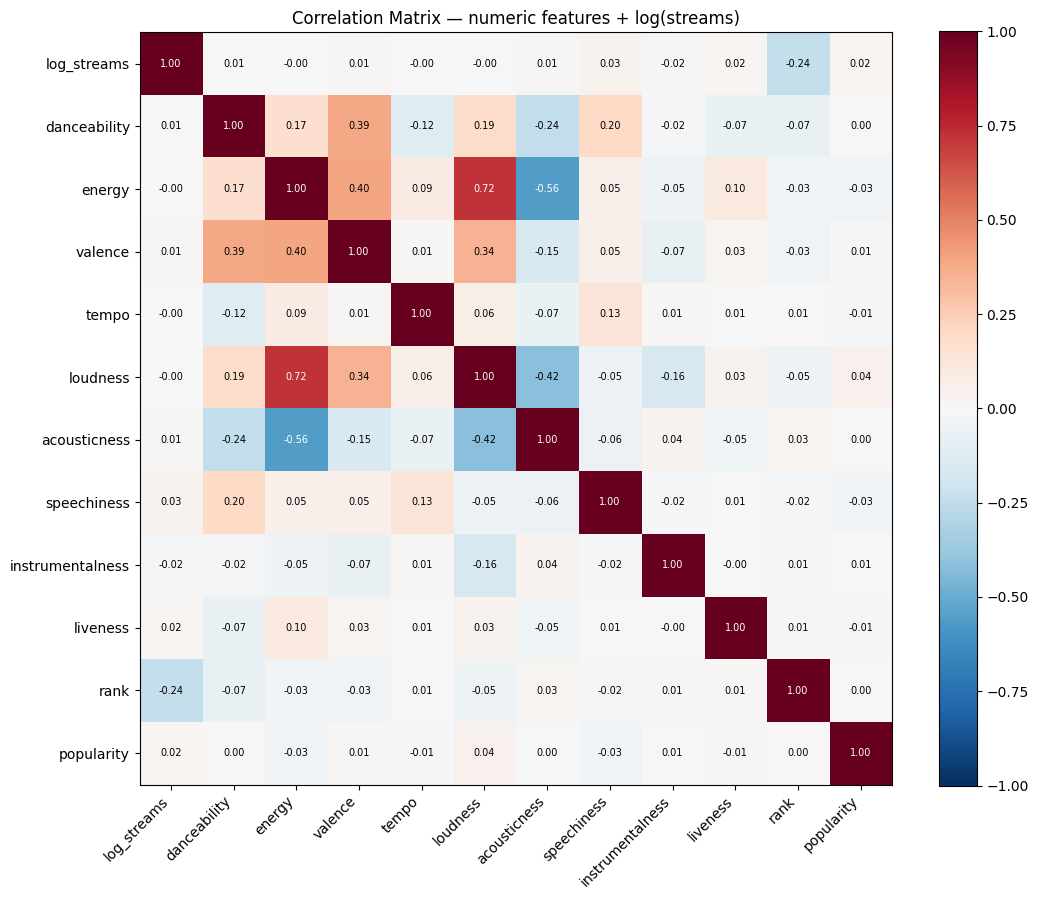


Correlations with log(streams) (sorted):
rank               -0.240094
speechiness         0.034953
popularity          0.020870
liveness            0.019484
instrumentalness   -0.017116
valence             0.009024
acousticness        0.007902
danceability        0.007741
energy             -0.003080
loudness           -0.000972
tempo              -0.000645


In [ ]:
numeric_cols_for_corr = ["log_streams", "danceability", "energy", "valence",
                          "tempo", "loudness", "acousticness", "speechiness",
                          "instrumentalness", "liveness", "rank", "popularity"]

corr = sample_df[numeric_cols_for_corr].dropna().corr()

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=7,
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

ax.set_title("Correlation Matrix — numeric features + log(streams)")
plt.tight_layout()
plt.show()

# Print top correlations with target
print("\nCorrelations with log(streams) (sorted):")
print(corr["log_streams"].drop("log_streams").sort_values(key=abs, ascending=False).to_string())


## 13) Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (37378, 14)
Train size: (28033, 13)  Test size: (9345, 13)


## 14) Baseline: Linear Regression

We fit a standard **least-squares linear regression**
and evaluate with:

- **RMSE** (in log-streams units)
- **R²** (fraction of variance explained)

**Checkpoint (think about these before running the next cell):**
- What does RMSE mean here if our target is `log(streams)`?
- What R² would you consider "good" for streaming data?


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ── Fit linear regression pipeline ──
lr_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

lr_pipe.fit(X_train, y_train)

# ── Predictions ──
y_train_pred = lr_pipe.predict(X_train)
y_test_pred  = lr_pipe.predict(X_test)

# ── Metrics ──
print("=== Linear Regression — Train ===")
print(f"  RMSE : {rmse(y_train, y_train_pred):.4f}")
print(f"  R²   : {r2_score(y_train, y_train_pred):.4f}")

print("\n=== Linear Regression — Test ===")
print(f"  RMSE : {rmse(y_test, y_test_pred):.4f}")
print(f"  R²   : {r2_score(y_test, y_test_pred):.4f}")

# ── Cross-validation on train set ──
cv_r2 = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring="r2")
print(f"\n5-fold CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


=== Linear Regression — Train ===
  RMSE : 1.4246
  R²   : 0.0442

=== Linear Regression — Test ===
  RMSE : 1.4290
  R²   : 0.0441

5-fold CV R²: 0.0430 ± 0.0035


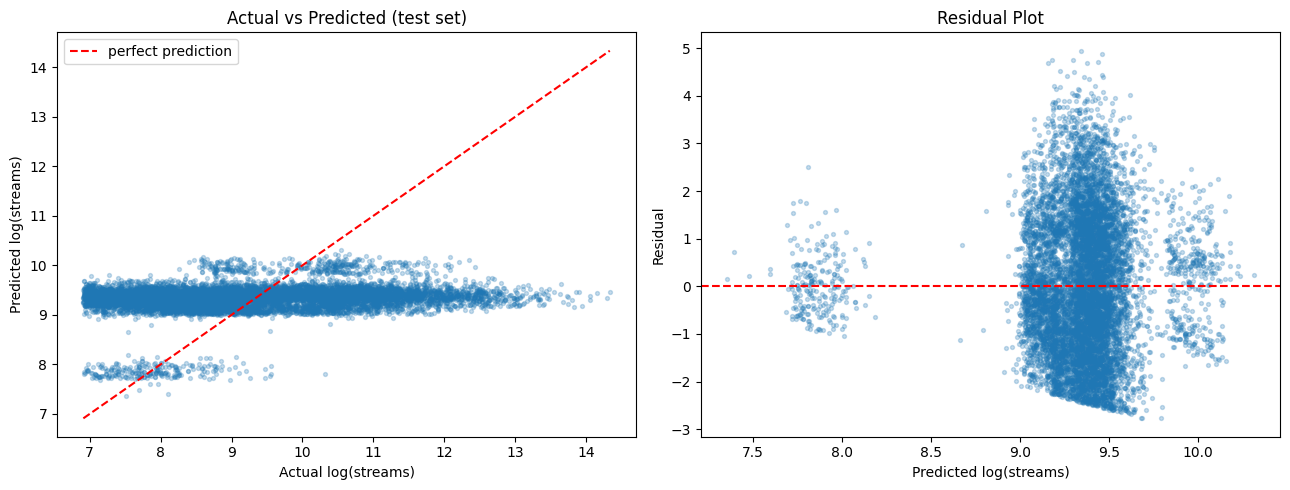

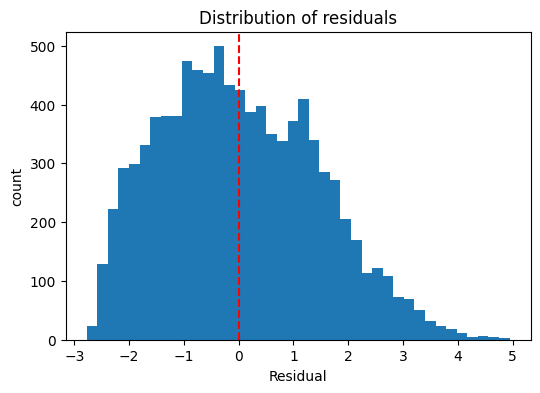

In [ ]:
# ── Actual vs Predicted — diagnostic plot ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.25, s=8)
lo = min(y_test.min(), y_test_pred.min())
hi = max(y_test.max(), y_test_pred.max())
axes[0].plot([lo, hi], [lo, hi], "r--", lw=1.5, label="perfect prediction")
axes[0].set_xlabel("Actual log(streams)")
axes[0].set_ylabel("Predicted log(streams)")
axes[0].set_title("Actual vs Predicted (test set)")
axes[0].legend()

# Residuals
residuals = y_test.values - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.25, s=8)
axes[1].axhline(0, color="red", lw=1.5, linestyle="--")
axes[1].set_xlabel("Predicted log(streams)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="none")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of residuals")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()




## 15) Coefficient Inspection

statsmodels OLS summary. We extract the linear regression coefficients
to understand which features drive the model.


Top 15 most influential features (by |coefficient|):


,feature,coefficient,abs_coefficient
14,country_continent_Oceania,2.107366,2.107366
15,country_continent_South America,1.627273,1.627273
12,country_continent_Europe,1.564512,1.564512
13,country_continent_North America,1.436529,1.436529
11,country_continent_Asia,1.291788,1.291788
10,explicit_True,0.133591,0.133591
0,danceability,-0.040590,0.040590
5,acousticness,0.039076,0.039076
6,speechiness,0.035886,0.035886
2,valence,0.028365,0.028365



Model Intercept: 7.815934088019495


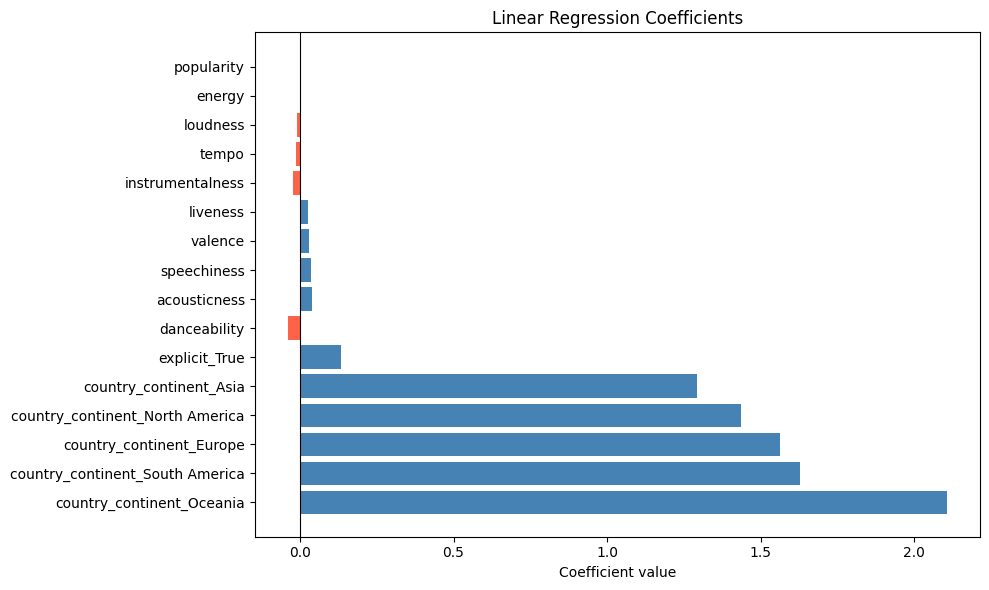

In [ ]:
# Extract feature names after preprocessing
ohe_cats = lr_pipe.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(CATEGORICAL_FEATURES).tolist()
feature_names = NUMERIC_FEATURES + ohe_cats

# Create DataFrame with normal and absolute coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_pipe.named_steps["model"].coef_,
})
# Calculate the absolute value of the coefficients
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

# Sort by absolute value and display the top 15
coef_df = coef_df.sort_values("abs_coefficient", ascending=False)
print("Top 15 most influential features (by |coefficient|):")
display(coef_df.head(15))

# Extract and print the model intercept
intercept = lr_pipe.named_steps["model"].intercept_
print(f"\nModel Intercept: {intercept}")

# Bar chart of all coefficients
fig, ax = plt.subplots(figsize=(10, 6))
# Ensure chart remains sorted by influence for readability
colors = ["steelblue" if c >= 0 else "tomato" for c in coef_df["coefficient"]]
ax.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
ax.axvline(0, color="black", lw=0.8)
ax.set_title("Linear Regression Coefficients")
ax.set_xlabel("Coefficient value")
plt.tight_layout()
plt.show()

## Interpreting the linear model coefficients (what increases/decreases predictions)

**Rule:**  
- **Positive coefficient (+)** → increases the prediction  
- **Negative coefficient (−)** → decreases the prediction  
- For **dummy variables** (e.g., `country_continent_Europe`), the coefficient is the effect **relative to the omitted reference category** (the continent that has no dummy).

### If the target is `log(streams)` (as in our EDA)
Then coefficients are easiest to read as **multiplicative / % effects**:

- A coefficient **β** corresponds to multiplying streams by **exp(β)**  
- Approx. percent change: **(exp(β) − 1) × 100%**

### Which variables increase predictions?
Largest positive effects (vs. reference continent):
- `country_continent_Oceania` **(+2.059)** → exp(2.059) ≈ **7.84×** (≈ **+684%**)
- `country_continent_South America` **(+1.618)** → ≈ **5.05×** (≈ **+405%**)
- `country_continent_Europe` **(+1.600)** → ≈ **4.95×** (≈ **+395%**)
- `country_continent_North America` **(+1.482)** → ≈ **4.40×** (≈ **+340%**)
- `country_continent_Asia` **(+1.267)** → ≈ **3.55×** (≈ **+255%**)

Other positive effects:
- `explicit_True` **(+0.086)** → exp(0.086) ≈ **1.09×** (≈ **+9%**)
- Small positives: `acousticness`, `liveness`, `valence`, `tempo`, `popularity`, `energy`

### Which variables decrease predictions?
- `danceability` **(−0.027)**
- `instrumentalness` **(−0.021)**
- `loudness` **(−0.020)**

(If the target is log(streams), β = −0.027 means exp(−0.027) ≈ **0.973×** → about **−2.7%** for a +1 unit change in that feature.)

### Are effects large or small?
- **Very large:** the **continent dummies** (coefficients ~1.3–2.1) dominate the model → they change predictions by **multiples**.
- **Medium:** `explicit_True` (~0.086) → around **single-digit %** effect.
- **Small:** most audio features have |β| around **0.02–0.03** (small changes in predicted log(streams)).

 Important: comparing “importance” by |coefficient| only makes sense if features are on **similar scales** (e.g., standardized). If not standardized, coefficient size also reflects the feature’s units (tempo in BPM, popularity 0–100, etc.).

### Are signs intuitive?
- **Instrumentalness negative**: intuitive (instrumentals often stream less in mainstream charts).
- **Popularity positive**: intuitive.
- **Continent effects**: plausible (differences in market size / Spotify usage / chart mechanics), but not causal.
- **Danceability negative / loudness negative**: might be counterintuitive and can depend on **scaling**, omitted variables, or correlations among features (multicollinearity). These signs should be discussed as “associations,” not causal effects.

**Intercept:** 7.83 means the baseline prediction (when all features = 0 and the reference categories apply) is **log(streams)=7.83** (streams ≈ exp(7.83) ≈ 2,517), but this baseline may not be realistic if “0” is outside typical feature values.


## 16) Regularization: Ridge | Lasso | ElasticNet

### Why Regularization?
Real datasets often have:
- Multicollinearity (e.g. energy and loudness are correlated)
- Noise
- Many one-hot-encoded dummy features

**Ridge** adds an L2 penalty to shrink all coefficients; **Lasso** adds an L1 penalty and can zero out irrelevant features.
Both reduce overfitting and improve generalization.**ElasticNet** is a modebel which behaves like Ridge (stable) + Lasso (some selection)
,especially good when predictors are correlated and you want interpretability.

In [ ]:
rows = []

ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
enet_alphas  = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios    = [0.2, 0.5, 0.8]

# --- LinearRegression ---
pipe = Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
pipe.fit(X_train, y_train)
rows.append({
    "train_rmse": rmse(y_train, pipe.predict(X_train)),
    "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
    "train_r2":   r2_score(y_train, pipe.predict(X_train)),
    "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
    "model":      "LinearRegression",
    "alpha":      np.nan
})

# --- Ridge ---
for a in ridge_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=a))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Ridge",
        "alpha":      a
    })

# --- Lasso ---
for a in lasso_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=a, max_iter=20000))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Lasso",
        "alpha":      a
    })

# --- ElasticNet (encode l1_ratio into model name so column isn't needed) ---
for a in enet_alphas:
    for r in l1_ratios:
        pipe = Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=a, l1_ratio=r, max_iter=20000))])
        pipe.fit(X_train, y_train)
        rows.append({
            "train_rmse": rmse(y_train, pipe.predict(X_train)),
            "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
            "train_r2":   r2_score(y_train, pipe.predict(X_train)),
            "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
            "model":      f"ElasticNet(r={r})",
            "alpha":      a
        })

results_df = pd.DataFrame(rows)
results_df[["train_rmse","test_rmse","train_r2","test_r2"]] = results_df[["train_rmse","test_rmse","train_r2","test_r2"]].round(6)
results_df["alpha"] = results_df["alpha"].round(6)

results_df = results_df.sort_values(["test_rmse", "test_r2"], ascending=[True, False]).reset_index(drop=True)
display(results_df)


,train_rmse,test_rmse,train_r2,test_r2,model,alpha
0,1.424646,1.428949,0.044231,0.044144,Lasso,0.0001
1,1.424642,1.428950,0.044236,0.044143,LinearRegression,NaN
2,1.424642,1.428950,0.044236,0.044143,Ridge,0.0010
3,1.424642,1.428950,0.044236,0.044143,Ridge,0.0100
4,1.424642,1.428951,0.044236,0.044143,Ridge,0.1000
5,1.424643,1.428954,0.044235,0.044138,Ridge,1.0000
6,1.424747,1.429076,0.044095,0.043975,Ridge,10.0000
7,1.425017,1.429279,0.043733,0.043703,Lasso,0.0010
8,1.425074,1.429356,0.043657,0.043600,ElasticNet(r=0.8),0.0010
9,1.425158,1.429470,0.043544,0.043447,ElasticNet(r=0.5),0.0010


Best config per model family (by test RMSE):


,model,alpha,test_rmse,test_r2
0,ElasticNet(r=0.2),0.0010,1.429583,0.043296
1,ElasticNet(r=0.5),0.0010,1.429470,0.043447
2,ElasticNet(r=0.8),0.0010,1.429356,0.043600
3,Lasso,0.0001,1.428949,0.044144
4,LinearRegression,NaN,1.428950,0.044143
5,Ridge,0.0010,1.428950,0.044143


ElasticNet(r=0.2)  (alpha=0.001)
  CV RMSE per fold : [1.4205 1.4172 1.4165 1.4392 1.437 ]
  Mean CV RMSE     : 1.4261
  Std  CV RMSE     : 0.0099

ElasticNet(r=0.5)  (alpha=0.001)
  CV RMSE per fold : [1.4205 1.4171 1.4164 1.4391 1.4369]
  Mean CV RMSE     : 1.4260
  Std  CV RMSE     : 0.0099

ElasticNet(r=0.8)  (alpha=0.001)
  CV RMSE per fold : [1.4205 1.4169 1.4163 1.439  1.4367]
  Mean CV RMSE     : 1.4259
  Std  CV RMSE     : 0.0099

Lasso  (alpha=0.0001)
  CV RMSE per fold : [1.4203 1.4165 1.4158 1.4388 1.436 ]
  Mean CV RMSE     : 1.4255
  Std  CV RMSE     : 0.0099

LinearRegression  (alpha=nan)
  CV RMSE per fold : [1.4203 1.4166 1.4158 1.4388 1.436 ]
  Mean CV RMSE     : 1.4255
  Std  CV RMSE     : 0.0099

Ridge  (alpha=0.001)
  CV RMSE per fold : [1.4203 1.4166 1.4158 1.4388 1.436 ]
  Mean CV RMSE     : 1.4255
  Std  CV RMSE     : 0.0099

CV summary (sorted by Mean CV RMSE):


,model,alpha,cv_rmse_mean,cv_rmse_std,test_rmse,gap (cv - test)
0,Lasso,0.0001,1.4255,0.0099,1.428949,-0.0034
1,LinearRegression,NaN,1.4255,0.0099,1.428950,-0.0034
2,Ridge,0.0010,1.4255,0.0099,1.428950,-0.0034
3,ElasticNet(r=0.8),0.0010,1.4259,0.0099,1.429356,-0.0035
4,ElasticNet(r=0.5),0.0010,1.4260,0.0099,1.429470,-0.0035
5,ElasticNet(r=0.2),0.0010,1.4261,0.0099,1.429583,-0.0035


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_47994/258923075.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


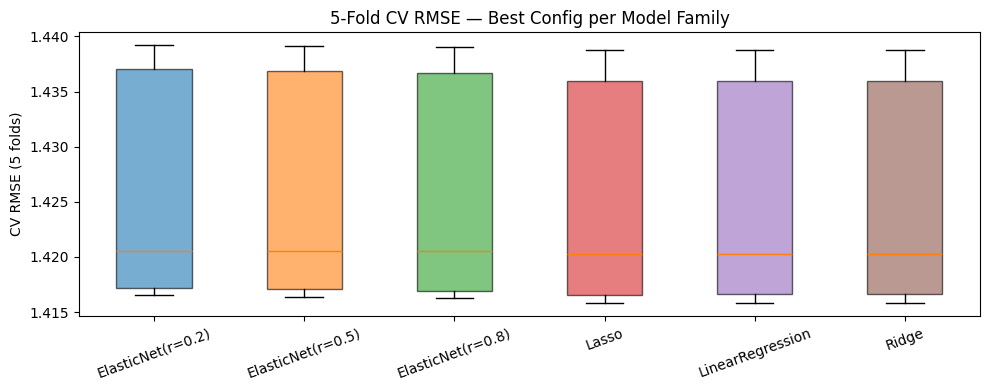

In [ ]:
# ── Pick the best alpha per model family from the grid search ─────────────────
# We take the row with the lowest test_rmse for each model family.
# ElasticNet variants are grouped by their full name (which encodes l1_ratio).

best_configs = (
    results_df
    .loc[results_df.groupby("model")["test_rmse"].idxmin()]
    .reset_index(drop=True)
)
print("Best config per model family (by test RMSE):")
display(best_configs[["model", "alpha", "test_rmse", "test_r2"]])

# ── Build the winning pipelines ───────────────────────────────────────────────
def build_pipe(model_name: str, alpha: float) -> Pipeline:
    if model_name == "LinearRegression":
        return Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
    elif model_name == "Ridge":
        return Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=alpha))])
    elif model_name == "Lasso":
        return Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=alpha, max_iter=20000))])
    elif model_name.startswith("ElasticNet"):
        # parse l1_ratio from the encoded name, e.g. "ElasticNet(r=0.5)"
        l1 = float(model_name.split("r=")[1].rstrip(")"))
        return Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=20000))])
    else:
        raise ValueError(f"Unknown model: {model_name}")

# ── 5-fold CV on the BEST config per family ───────────────────────────────────
# cross_val_score returns *negative* RMSE → multiply by -1

cv_rows = []

for _, row in best_configs.iterrows():
    name  = row["model"]
    alpha = row["alpha"]
    pipe  = build_pipe(name, alpha)

    neg_rmse_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    rmse_scores = -neg_rmse_scores

    cv_rows.append({
        "model":          name,
        "alpha":          alpha,
        "cv_rmse_mean":   round(rmse_scores.mean(), 4),
        "cv_rmse_std":    round(rmse_scores.std(),  4),
        "fold_scores":    rmse_scores.round(4).tolist(),
        "test_rmse":      row["test_rmse"],   # from grid search — for comparison
    })

    print(f"{name}  (alpha={alpha})")
    print(f"  CV RMSE per fold : {rmse_scores.round(4)}")
    print(f"  Mean CV RMSE     : {rmse_scores.mean():.4f}")
    print(f"  Std  CV RMSE     : {rmse_scores.std():.4f}")
    print()

# ── Summary table ─────────────────────────────────────────────────────────────
cv_summary = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean").reset_index(drop=True)
cv_summary["gap (cv - test)"] = (cv_summary["cv_rmse_mean"] - cv_summary["test_rmse"]).round(4)
print("CV summary (sorted by Mean CV RMSE):")
display(cv_summary[["model", "alpha", "cv_rmse_mean", "cv_rmse_std", "test_rmse", "gap (cv - test)"]])

# ── Boxplot: CV RMSE spread per winning model ─────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
labels = [r["model"] for r in cv_rows]
data   = [r["fold_scores"] for r in cv_rows]
bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = plt.cm.tab10.colors
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel("CV RMSE (5 folds)")
ax.set_title("5-Fold CV RMSE — Best Config per Model Family")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()

## 17) Gradient Descent — From Scratch



This section is for *conceptual reinforcement*. We re-implement linear regression
using **batch gradient descent** on the same preprocessed design matrix, then compare
results to sklearn's closed-form solution.

**How it works:**
1. Start with `θ = 0` (all-zero coefficients)
2. Compute predictions: `ŷ = X · θ`
3. Compute gradient of MSE: `∇ = (2/m) · Xᵀ(ŷ − y)`
4. Update: `θ ← θ − lr · ∇`
5. Repeat for `n_iter` steps

**Checkpoint (think about these before running):**
- What happens if the learning rate `lr` is too high? Too low?
- How do we know we've converged?
- Why must features be standardised before gradient descent?

## Why Gradient Descent Matters
This section shows *how* models learn under the hood:
- Start with random / zero coefficients
- Iteratively reduce the training error
- Converge toward the optimal solution

Focus on the concept — not every line of maths.


In [ ]:
# ── Step 1: Extract the preprocessed design matrix ──────────────────────────
# Reuse the already-fit preprocessor from lr_pipe (section 13)
# Refit here so this cell works even if run out of order
preprocess_fit = preprocess.fit(X_train)

X_train_gd = preprocess_fit.transform(X_train)
X_test_gd  = preprocess_fit.transform(X_test)

# Convert to dense if sparse
X_train_gd = X_train_gd.toarray() if hasattr(X_train_gd, "toarray") else X_train_gd
X_test_gd  = X_test_gd.toarray()  if hasattr(X_test_gd,  "toarray") else X_test_gd

# ── Step 2: Prepend intercept column (column of 1s) ──────────────────────────
X_train_gd = np.c_[np.ones(X_train_gd.shape[0]), X_train_gd]
X_test_gd  = np.c_[np.ones(X_test_gd.shape[0]),  X_test_gd]

print(f"X_train_gd shape: {X_train_gd.shape}  (includes intercept column)")
print(f"X_test_gd  shape: {X_test_gd.shape}")


X_train_gd shape: (28033, 17)  (includes intercept column)
X_test_gd  shape: (9345, 17)


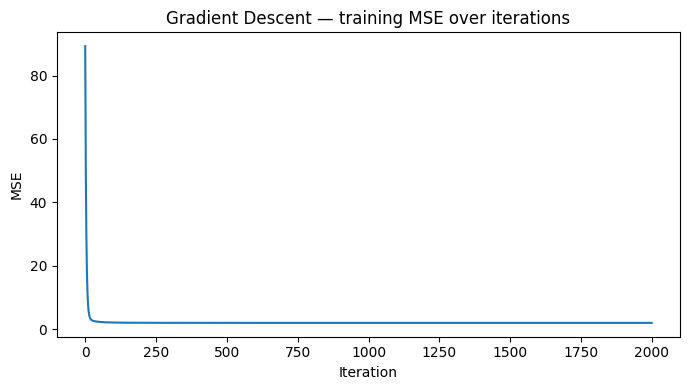

In [ ]:
# ── Step 3: Gradient Descent implementation ──────────────────────────────────
def gradient_descent(X, y, lr=0.05, n_iter=2000):
    """Batch gradient descent for linear regression (MSE loss).

    Parameters
    ----------
    X      : (m, n+1) design matrix with intercept column prepended
    y      : (m,) target vector
    lr     : learning rate
    n_iter : number of gradient steps

    Returns
    -------
    theta   : (n+1,) learned coefficient vector
    history : (n_iter,) MSE at each iteration
    """
    theta = np.zeros(X.shape[1])  # initialise all weights at 0
    m = X.shape[0]
    history = []
    for _ in range(n_iter):
        y_pred = X @ theta                          # forward pass
        grad   = (2 / m) * (X.T @ (y_pred - y))    # gradient of MSE
        theta -= lr * grad                          # weight update
        history.append(mean_squared_error(y, y_pred))
    return theta, np.array(history)


theta_gd, mse_hist = gradient_descent(
    X_train_gd, y_train.values, lr=0.05, n_iter=2000
)

# ── Step 4: Plot training MSE convergence ────────────────────────────────────
plt.figure(figsize=(7, 4))
plt.plot(mse_hist, lw=1.5)
plt.title("Gradient Descent — training MSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()


Model                              RMSE       R²
---------------------------------------------
sklearn LinearRegression         1.4290   0.0441
Gradient Descent (lr=0.05, 2000 iters)   1.4290   0.0441

Both should be very close — gradient descent converges to the same minimum.
If they differ, try increasing n_iter or decreasing lr.


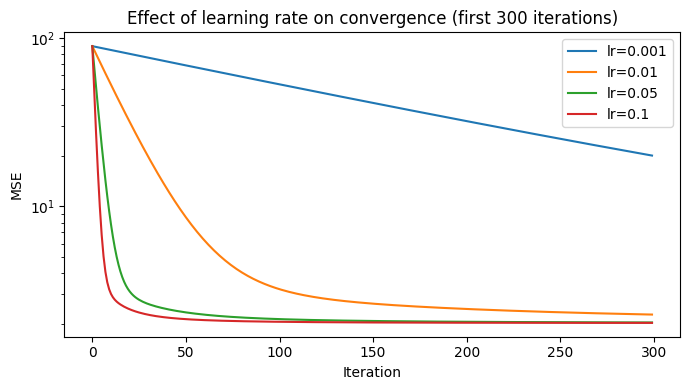

In [ ]:
# ── Step 5: Evaluate on test set and compare to sklearn's closed-form ────────
y_test_pred_gd = X_test_gd @ theta_gd

rmse_gd = rmse(y_test, y_test_pred_gd)
r2_gd   = float(r2_score(y_test, y_test_pred_gd))

# Retrieve sklearn closed-form results from section 13
rmse_lr = rmse(y_test, y_test_pred)
r2_lr   = float(r2_score(y_test, y_test_pred))

print("=" * 45)
print(f"{'Model':<30} {'RMSE':>8} {'R²':>8}")
print("-" * 45)
print(f"{'sklearn LinearRegression':<30} {rmse_lr:>8.4f} {r2_lr:>8.4f}")
print(f"{'Gradient Descent (lr=0.05, 2000 iters)':<30} {rmse_gd:>8.4f} {r2_gd:>8.4f}")
print("=" * 45)
print("\nBoth should be very close — gradient descent converges to the same minimum.")
print("If they differ, try increasing n_iter or decreasing lr.")

# sensitivity to learning rate ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
for lr_val in [0.001, 0.01, 0.05, 0.1]:
    _, hist = gradient_descent(X_train_gd, y_train.values, lr=lr_val, n_iter=300)
    ax.plot(hist, label=f"lr={lr_val}")

ax.set_title("Effect of learning rate on convergence (first 300 iterations)")
ax.set_xlabel("Iteration")
ax.set_ylabel("MSE")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()
